In [1]:
import pandas as pd
import numpy as np
import xgboost as xgbd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, plot_importance
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from yellowbrick.model_selection import feature_importances







In [2]:
df = pd.read_csv('covid-19_data_ntr.csv', sep=',\s+', parse_dates=[3], delimiter=',', encoding="utf-8",
                 skipinitialspace=True)
print(df)
print(df.dtypes)

          FISNumber  FamilyNumber  sex     invd15  age15  koorts15  hoest15  \
0      514330001768       60356.0  2.0 2020-04-29   37.0       3.0      2.0   
1      514330002472       60358.0  2.0 2020-04-30   37.0       1.0      2.0   
2      514330007179       60344.0  2.0 2020-05-01   48.0       1.0      1.0   
3      514330008061       60338.0  1.0 2020-05-04   33.0       1.0      1.0   
4      514330008945       60338.0  2.0 2020-04-30   33.0       1.0      2.0   
...             ...           ...  ...        ...    ...       ...      ...   
19705  514369987591       37736.0  1.0 2020-05-05   58.0       1.0      2.0   
19706  514369990903       35816.0  2.0 2020-04-30   51.0       NaN      NaN   
19707  514369991065       35824.0  1.0 2020-04-29   53.0       1.0      2.0   
19708  514369996614       35812.0  2.0 2020-04-30   51.0       1.0      2.0   
19709  514369999499       38979.0  1.0 2020-04-29   50.0       1.0      2.0   

       keelpijn15  verkouden15  diarree15  ...  gzn

In [3]:
# converting Invd15 variable into date format
df['day'] = df['invd15'].dt.day.astype(float)
df['month'] = df['invd15'].dt.month.astype(float)
df['year'] = df['invd15'].dt.year.astype(float)
df['weekday'] = df['invd15'].dt.weekday.astype(float)

#Dropping the columns containing date information
df.drop(columns='invd15', inplace=True)
print('Data after feature engineering for dates')
print(df)


Data after feature engineering for dates
          FISNumber  FamilyNumber  sex  age15  koorts15  hoest15  keelpijn15  \
0      514330001768       60356.0  2.0   37.0       3.0      2.0         2.0   
1      514330002472       60358.0  2.0   37.0       1.0      2.0         1.0   
2      514330007179       60344.0  2.0   48.0       1.0      1.0         3.0   
3      514330008061       60338.0  1.0   33.0       1.0      1.0         1.0   
4      514330008945       60338.0  2.0   33.0       1.0      2.0         1.0   
...             ...           ...  ...    ...       ...      ...         ...   
19705  514369987591       37736.0  1.0   58.0       1.0      2.0         NaN   
19706  514369990903       35816.0  2.0   51.0       NaN      NaN         NaN   
19707  514369991065       35824.0  1.0   53.0       1.0      2.0         2.0   
19708  514369996614       35812.0  2.0   51.0       1.0      2.0         2.0   
19709  514369999499       38979.0  1.0   50.0       1.0      2.0         2.0   

In [4]:
# Number of unique FISNumber to determine any recurring user

FISNumber = df.iloc[:, 0]
print('Total Number of FISNumber entries: ' + str(len(FISNumber)))
unique_users = FISNumber.unique()
print('Number of unique FISNumber: ' + str(len(unique_users)))

#Replacing outliers and NaN
df = df.replace(to_replace=8888888.0, value=0)
df_new = df.fillna(0)
print('After replacing all NaN and 8888888 values to 0 : ')
print(df_new)

df=df_new

print(df)


Total Number of FISNumber entries: 19710
Number of unique FISNumber: 19710
After replacing all NaN and 8888888 values to 0 : 
          FISNumber  FamilyNumber  sex  age15  koorts15  hoest15  keelpijn15  \
0      514330001768       60356.0  2.0   37.0       3.0      2.0         2.0   
1      514330002472       60358.0  2.0   37.0       1.0      2.0         1.0   
2      514330007179       60344.0  2.0   48.0       1.0      1.0         3.0   
3      514330008061       60338.0  1.0   33.0       1.0      1.0         1.0   
4      514330008945       60338.0  2.0   33.0       1.0      2.0         1.0   
...             ...           ...  ...    ...       ...      ...         ...   
19705  514369987591       37736.0  1.0   58.0       1.0      2.0         0.0   
19706  514369990903       35816.0  2.0   51.0       0.0      0.0         0.0   
19707  514369991065       35824.0  1.0   53.0       1.0      2.0         2.0   
19708  514369996614       35812.0  2.0   51.0       1.0      2.0         2


these are the patients who were confirmed to have
covid by care provider
This will be used to increase the training samples in the next round of training and subsequent DL model


In [5]:
# data of individuals with no PCR labels but with doc confirmation
confirmed_covid_n = df[df.tested_positive < 0]
#1-3 confirmed covid, 4-5 not confirmed but suscpected
confirmed_covid = confirmed_covid_n[confirmed_covid_n.covid19_15 < 4] 

# The physician label has been removed and converted to binary test as a proxy for PCR
confirmed_covid['covid19_15'].replace(to_replace=[2, 3], value=1, inplace=True)
confirmed_covid.drop(columns=['tested_positive'], inplace=True)
confirmed_covid = confirmed_covid.rename(columns={'covid19_15':'tested_positive'})
print('Doc Confirmed covid but no PCR result available: ')
print(confirmed_covid)

# Counting the different classes in the Doctor confirmed covid patients
neg, pos = np.bincount(confirmed_covid['tested_positive'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))

# these are the patients with PCR test results. Part of this data will be used to test the model performance.
tested_samples = df[df.tested_positive > -9999]
tested_samples.drop(columns=['covid19_15'], inplace=True)
tested_samples.sort_index(inplace=True)
print('PCR tested individuals: ')
print(tested_samples)

# Counting the different classes in the PCR tested patients
neg, pos = np.bincount(tested_samples['tested_positive'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))




Doc Confirmed covid but no PCR result available: 
          FISNumber  FamilyNumber  sex  age15  koorts15  hoest15  keelpijn15  \
0      514330001768       60356.0  2.0   37.0       3.0      2.0         2.0   
1      514330002472       60358.0  2.0   37.0       1.0      2.0         1.0   
2      514330007179       60344.0  2.0   48.0       1.0      1.0         3.0   
3      514330008061       60338.0  1.0   33.0       1.0      1.0         1.0   
4      514330008945       60338.0  2.0   33.0       1.0      2.0         1.0   
...             ...           ...  ...    ...       ...      ...         ...   
19705  514369987591       37736.0  1.0   58.0       1.0      2.0         0.0   
19706  514369990903       35816.0  2.0   51.0       0.0      0.0         0.0   
19707  514369991065       35824.0  1.0   53.0       1.0      2.0         2.0   
19708  514369996614       35812.0  2.0   51.0       1.0      2.0         2.0   
19709  514369999499       38979.0  1.0   50.0       1.0      2.0      

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [6]:
#Visualise the data with PCA
def PCA_data(data_new):
    y = pd.DataFrame((data_new.loc[:, ['tested_positive']].values), columns=['tested_positive'])
    columns_data = []
    for cols in data_new.columns:
        columns_data.append(cols)
    columns_data.remove('tested_positive')
    x = data_new.loc[:, columns_data].values
    x = MinMaxScaler().fit_transform(x) #Standardise the features
    #PCA with 2 components
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y], axis = 1)
    print('Explained Variance Ratio: ')
    print(pca.explained_variance_ratio_)
    return finalDf

In [7]:
#Running PCA and creating two dataframes for visualisation
print("PCA dataset for patients with No PCR test but confirmed by Physician")
doc_data_PCA = PCA_data(data_new=confirmed_covid)
print(doc_data_PCA)

print("PCA dataset for patients with PCR test")
tested_data_PCA = PCA_data(data_new=tested_samples)
print(tested_data_PCA)

PCA dataset for patients with No PCR test but confirmed by Physician
Explained Variance Ratio: 
[0.17615963 0.10263014]
       principal component 1  principal component 2  tested_positive
0                  -0.418211              -0.193938                1
1                   0.699452              -0.027070                0
2                  -0.459637               0.469840                0
3                  -0.233673               0.579933                0
4                   0.395897              -0.331677                0
...                      ...                    ...              ...
17761              -0.526643               0.137714                0
17762              -0.578805              -0.654170                0
17763              -0.466408              -0.287199                0
17764               0.412848              -0.480773                1
17765               0.702817              -0.126211                0

[17766 rows x 3 columns]
PCA dataset for patients w

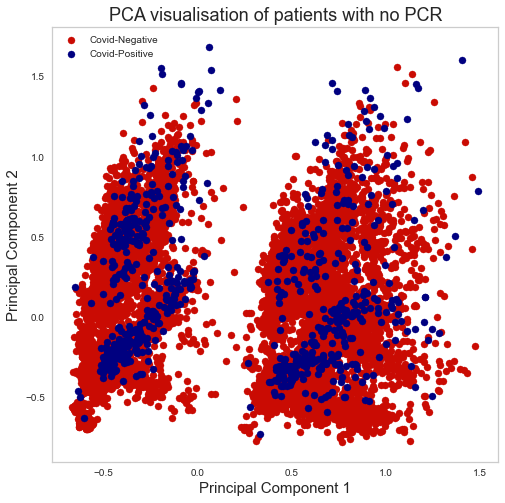

In [8]:
#Visualising Doc Confirmed Covid Patients
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA visualisation of patients with no PCR', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = doc_data_PCA['tested_positive'] == target
    ax.scatter(doc_data_PCA.loc[indicesToKeep, 'principal component 1']
               , doc_data_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax.legend(legends)
ax.grid()



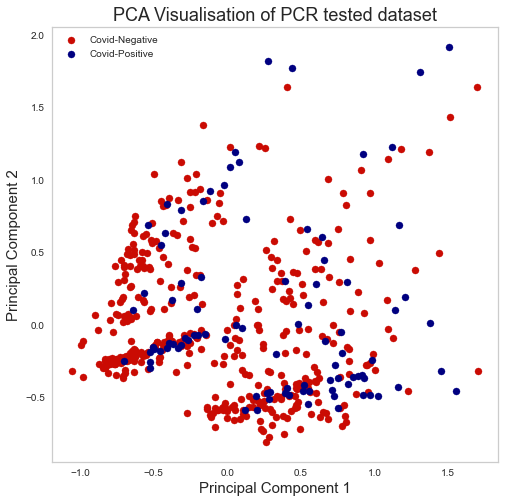

In [9]:
#Visualising PCR Confirmed Covid Patients
fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Visualisation of PCR tested dataset', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = tested_data_PCA['tested_positive'] == target
    ax.scatter(tested_data_PCA.loc[indicesToKeep, 'principal component 1']
               , tested_data_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax.legend(legends)
ax.grid()


In [337]:
#With stratifiedsplit we will seperate a test dataset from PCR tested patients

##The dataset without PCR result will be combined with the remaining patients in the PCR tested dataset
###Resulting dataset will be used in stratified-kfold-shufflesplit to carryout CV and select hyperparameters for Xgboost model


In [10]:
# Preparing for Splitting tested_samples
tested_labels = pd.DataFrame(((tested_samples.tested_positive).astype(int)))
tested_features = tested_samples.drop(columns={'FISNumber', 'tested_positive'})

#Splitting the data that contain the patients with PCR information
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
for train_index, test_index in skf.split(tested_features, tested_labels):
    print("TRAIN data size:", len(train_index), "TEST data size:", len(test_index))
    X_train, X_test = tested_features.iloc[train_index], tested_features.iloc[test_index]
    y_train, y_test = tested_labels.iloc[train_index], tested_labels.iloc[test_index]

print(X_train, y_train, X_test, y_test)

#Counting the different classes in Test set to ensure class balance
neg, pos = np.bincount(y_test['tested_positive'])
total = neg + pos
print('Examples in Test set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))

#Counting the different classes in Training set to ensure class balance maintained
neg, pos = np.bincount(y_train['tested_positive'])
total = neg + pos
print('Examples in Training set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))

tested_dataset = pd.concat((X_train, y_train), axis=1)
print("PCR dataset that will be combined with Doctor Dataset for training")
print(tested_dataset)


TRAIN data size: 256 TEST data size: 257
TRAIN data size: 257 TEST data size: 256
       FamilyNumber  sex  age15  koorts15  hoest15  keelpijn15  verkouden15  \
16          60692.0  2.0   33.0       1.0      0.0         2.0          2.0   
169         59762.0  2.0   36.0       1.0      1.0         1.0          2.0   
237         57714.0  2.0   29.0       1.0      2.0         2.0          3.0   
255         60861.0  2.0   39.0       1.0      4.0         2.0          4.0   
276         60849.0  2.0   36.0       2.0      3.0         2.0          5.0   
...             ...  ...    ...       ...      ...         ...          ...   
19417       35634.0  1.0   47.0       1.0      1.0         1.0          1.0   
19435       35463.0  2.0   57.0       1.0      0.0         1.0          1.0   
19542       36044.0  2.0   54.0       2.0      2.0         2.0          2.0   
19576       39394.0  1.0   87.0       1.0      4.0         4.0          1.0   
19624        4793.0  2.0   59.0       1.0      2.

In [11]:
#Combining confirmed_covid dataset (containing no PCR) with the tested_dataset 
confirmed_covid_t = confirmed_covid.drop(columns={'FISNumber'})
training_dataset = pd.concat((tested_dataset, confirmed_covid_t), axis=0)

print(training_dataset)

#Preparing new dataset with Doctor confirmed Patients and PCR confirmed patients
doc_labels = pd.DataFrame(((training_dataset.tested_positive).astype(int)))
doc_features = training_dataset.drop(columns={'tested_positive'})
print(doc_labels)


#Counting the different classes in Training set to ensure class balance maintained
neg, pos = np.bincount(doc_labels['tested_positive'])
total = neg + pos
print('Examples in Training set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))



       FamilyNumber  sex  age15  koorts15  hoest15  keelpijn15  verkouden15  \
16          60692.0  2.0   33.0       1.0      0.0         2.0          2.0   
169         59762.0  2.0   36.0       1.0      1.0         1.0          2.0   
237         57714.0  2.0   29.0       1.0      2.0         2.0          3.0   
255         60861.0  2.0   39.0       1.0      4.0         2.0          4.0   
276         60849.0  2.0   36.0       2.0      3.0         2.0          5.0   
...             ...  ...    ...       ...      ...         ...          ...   
19705       37736.0  1.0   58.0       1.0      2.0         0.0          0.0   
19706       35816.0  2.0   51.0       0.0      0.0         0.0          0.0   
19707       35824.0  1.0   53.0       1.0      2.0         2.0          2.0   
19708       35812.0  2.0   51.0       1.0      2.0         2.0          2.0   
19709       38979.0  1.0   50.0       1.0      2.0         2.0          2.0   

       diarree15  kortadem15  vrlreuk15  ...      B

In [12]:
#PCA for comparison and visualisation
print("PCA dataset for imbalanced training_dataset")
imbalanced_train_PCA = PCA_data(data_new=training_dataset)
print(imbalanced_train_PCA)

PCA dataset for imbalanced training_dataset
Explained Variance Ratio: 
[0.184448   0.10781211]
       principal component 1  principal component 2  tested_positive
0                  -0.273512              -0.027548                0
1                  -0.507899              -0.305030                0
2                   0.763064              -0.255037                0
3                  -0.303410               0.716735                0
4                   0.717085              -0.236475                0
...                      ...                    ...              ...
18018              -0.534857               0.143715                0
18019              -0.591516              -0.639411                0
18020              -0.472160              -0.272233                0
18021               0.406833              -0.468485                1
18022               0.699792              -0.119724                0

[18023 rows x 3 columns]


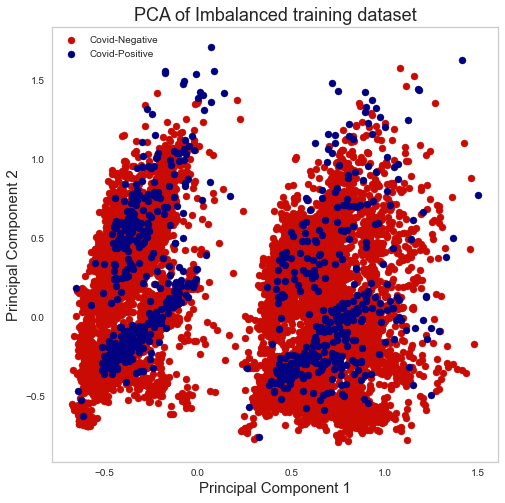

In [13]:
fig5 = plt.figure(figsize = (8,8))
ax5 = fig5.add_subplot(1,1,1) 
ax5.set_xlabel('Principal Component 1', fontsize = 15)
ax5.set_ylabel('Principal Component 2', fontsize = 15)
ax5.set_title('PCA of Imbalanced training dataset', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = imbalanced_train_PCA['tested_positive'] == target
    ax5.scatter(imbalanced_train_PCA.loc[indicesToKeep, 'principal component 1']
               , imbalanced_train_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax5.legend(legends)
ax5.grid()

In [342]:
training_dataset.to_csv('Training_dataset.csv', index=False)

In [44]:
def create_results(labels, prediction):
    print();
    print('XGBClassifier: ')
    print();
    print(metrics.classification_report(labels, prediction))
    print();
    print(metrics.confusion_matrix(labels, prediction))
    

In [45]:
def plot_cm(labels, predictions, name):
    
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(str(name))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print();
    print('Healthy Individuals Detected (True Negatives): ', cm[0][0])
    print('Healthy Individuals Incorrectly Detected (False Positives): ', cm[0][1])
    print('Covid-19 Patients not detected  (False Negatives): ', cm[1][0])
    print('Covid-19 Patients Detected (True Positives): ', cm[1][1])
    print('Total Covid-19 Patients in Data: ', np.sum(cm[1]))
    print();
    
    specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity1)

    sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity1 )
    
    precision1 = cm[1,1]/(cm[0,1]+cm[1,1])
    print('Precision : ', precision1 )
    
    f1_score1 = cm[1,1]/(cm[1,1]+(cm[0,1]+cm[1,0])/2)
    print('F1-Score : ', f1_score1 )
    
    print();

In [46]:
def plot_metrics(history):
	metrics = ['loss', 'auc', 'precision', 'recall']
	for n, metric in enumerate(metrics):
		name = metric.replace("_", " ").capitalize()
		plt.subplot(2, 2, n + 1)
		plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
		plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], linestyle="--", label='Val')
		plt.xlabel('Epoch')
		plt.ylabel(name)
		if metric == 'loss':
			plt.ylim([0, plt.ylim()[1]])
		elif metric == 'auc':
			plt.ylim([0.8, 1])
		else:
			plt.ylim([0, 1])
		plt.legend()

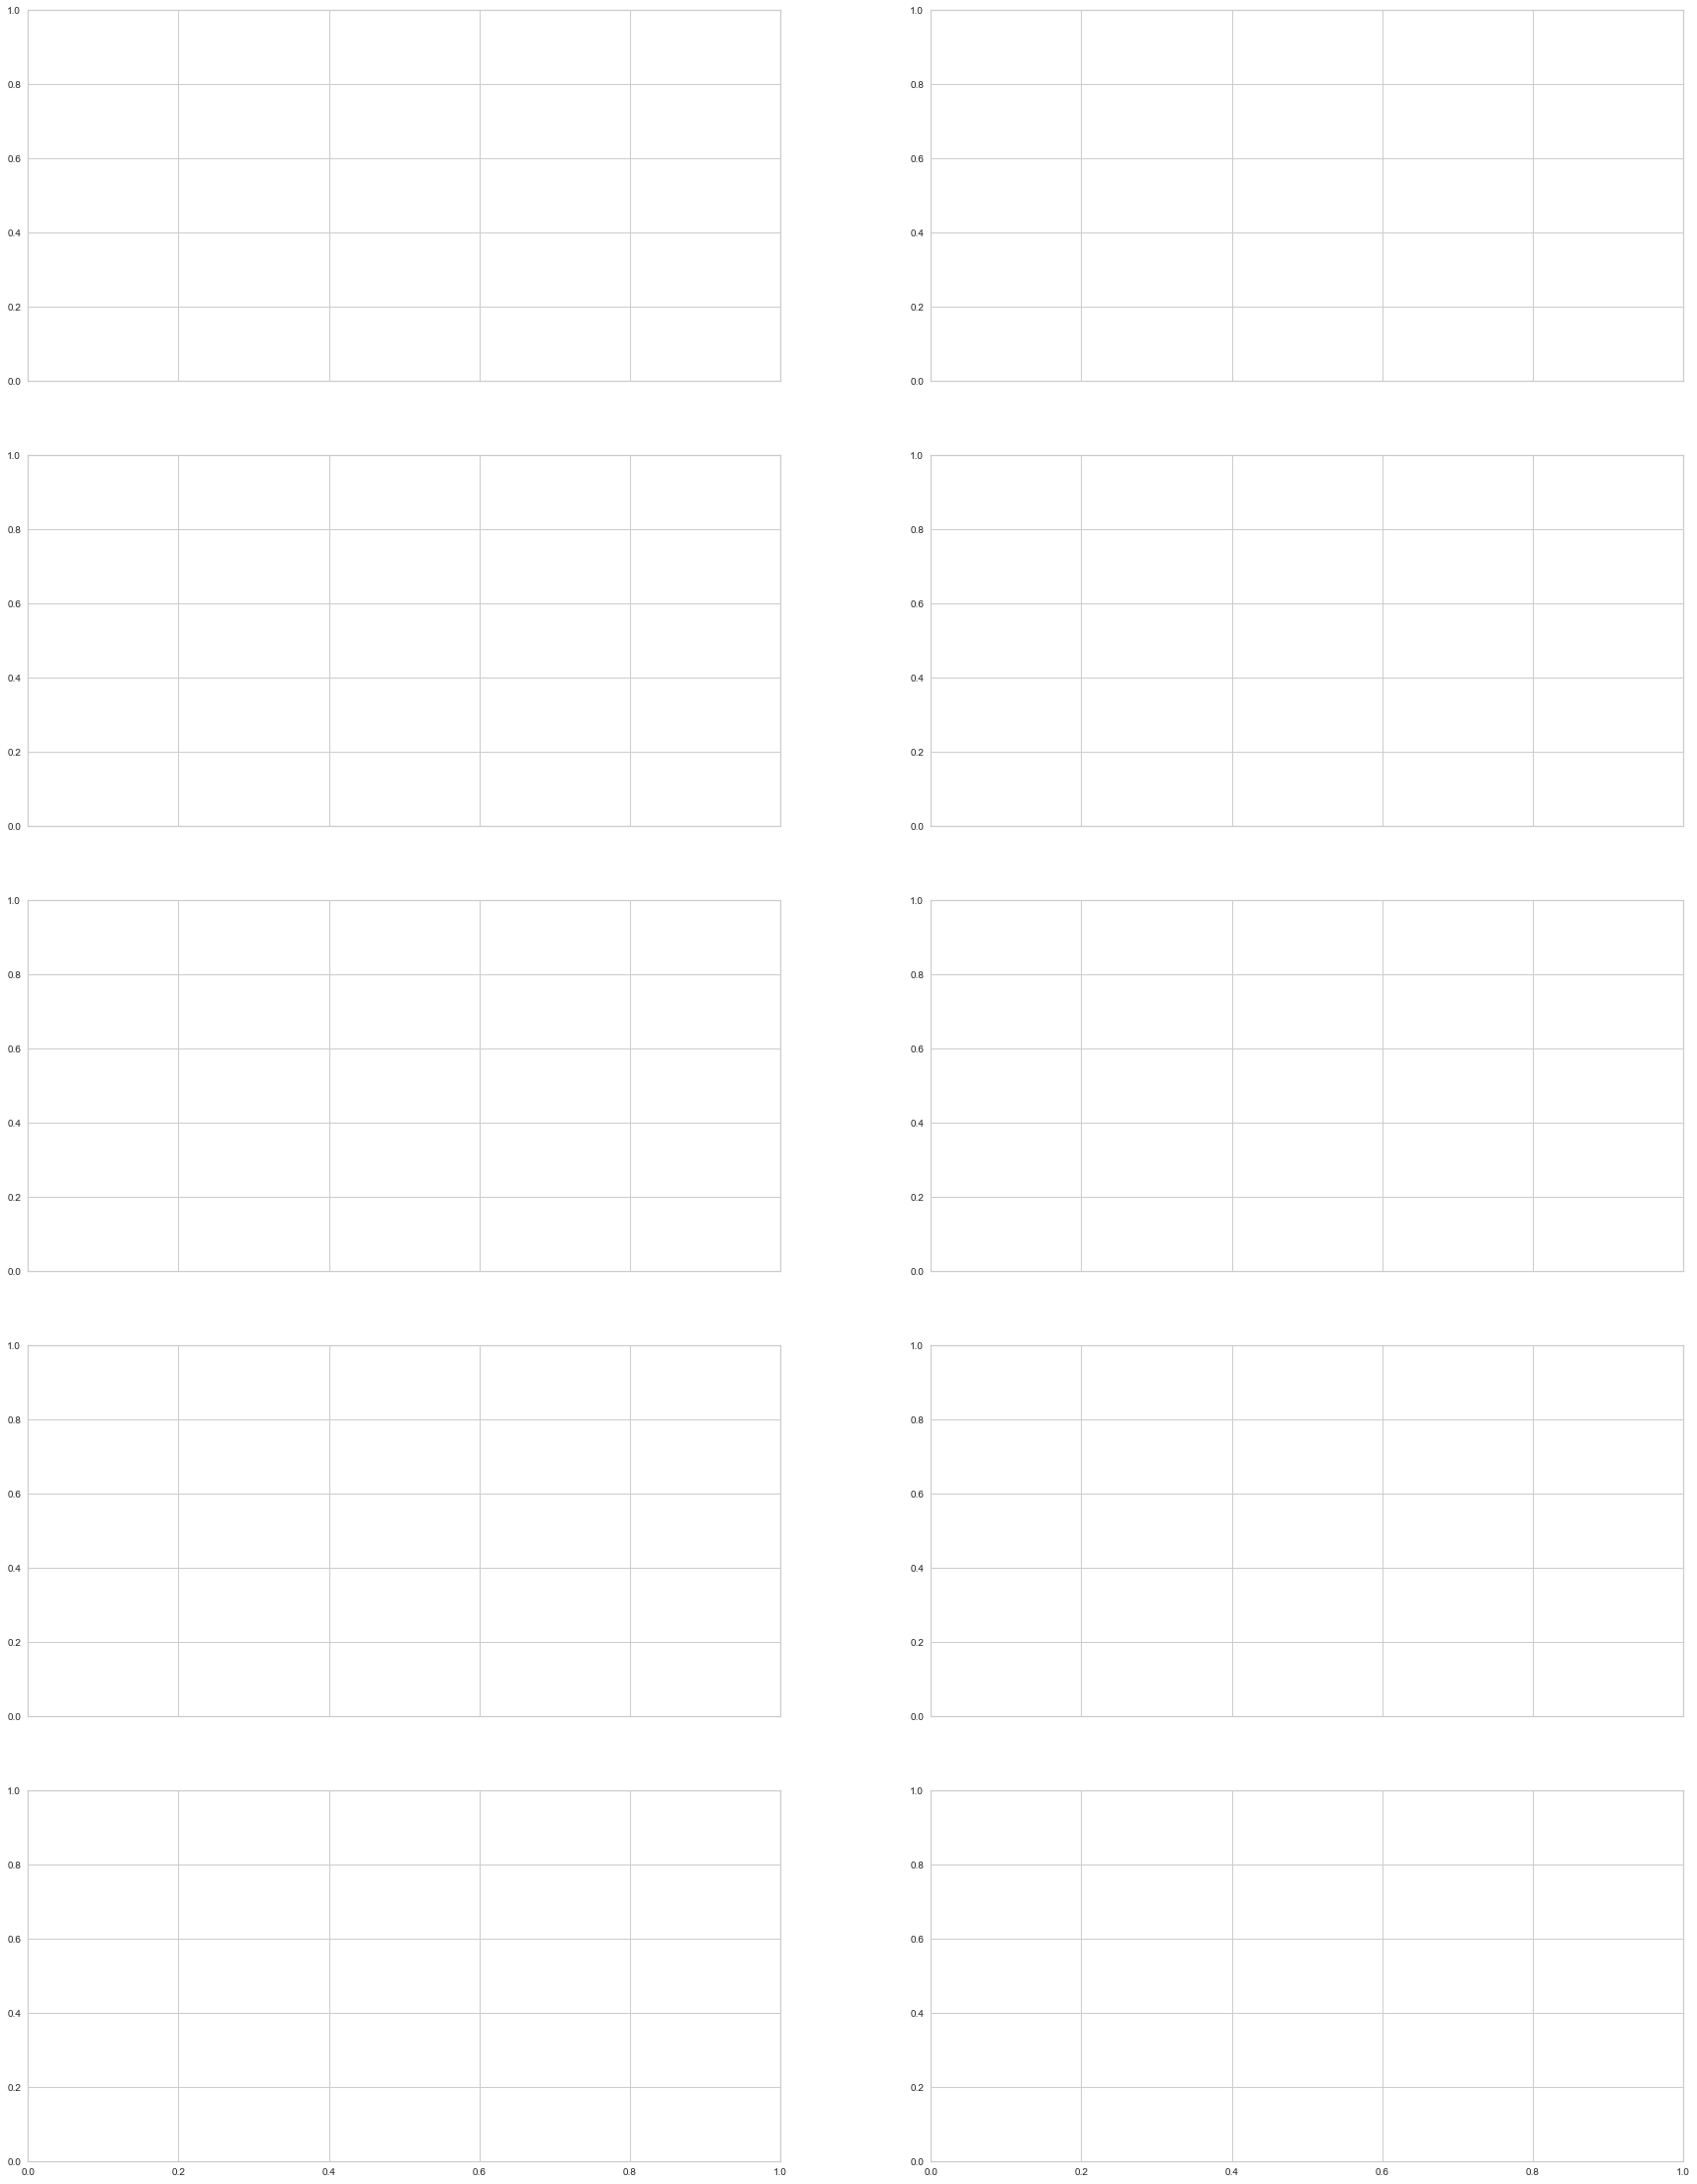

In [139]:
#creating cv split instance and Figure for recording feature importance
fig_feat, axs = plt.subplots(5, 2, figsize=(30, 40), sharex=True)
cv_split = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=5)


In [471]:
#Setting baseline by training on the dataset created and tested on the PCR test set.
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cross_score_1 = cross_val_score(xgb, doc_features, doc_labels, cv=cv_split, scoring='f1_macro')
xgb.fit(doc_features, doc_labels)
prediction = xgb.predict(X_test)


Baseline Xgboost classifier without hyperparameter tuning

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       211
           1       0.50      0.49      0.49        45

    accuracy                           0.82       256
   macro avg       0.70      0.69      0.69       256
weighted avg       0.82      0.82      0.82       256


[[189  22]
 [ 23  22]]

Healthy Individuals Detected (True Negatives):  189
Healthy Individuals Incorrectly Detected (False Positives):  22
Covid-19 Patients not detected  (False Negatives):  23
Covid-19 Patients Detected (True Positives):  22
Total Covid-19 Patients in Data:  45

Specificity :  0.8957345971563981
Sensitivity :  0.4888888888888889
Precision :  0.5
F1-Score :  0.4943820224719101

Roc curve on test set: 


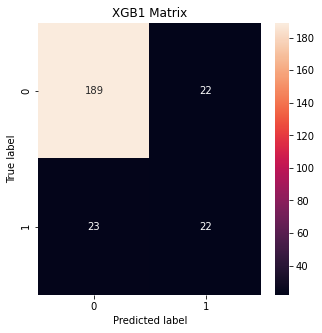

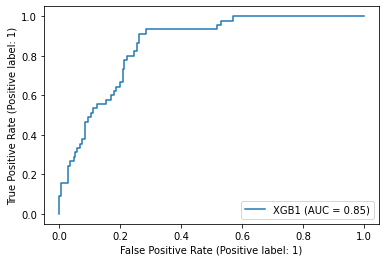

In [485]:
print('Baseline Xgboost classifier without hyperparameter tuning')
create_results(y_test, prediction)
plot_cm(y_test, prediction, name='XGB1 Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb, X_test, y_test, name='XGB1')

In [37]:
#create synthetic data for positive PCR cases using SMOTE
#the resulting df will be labelled as X_sm and y_sm
# define pipeline
over_samp = SMOTE(sampling_strategy=0.1, random_state=3)
under_samp = RandomUnderSampler(sampling_strategy=0.8, random_state=7)
steps = [('o', over_samp), ('u', under_samp)]
pipeline = Pipeline(steps=steps)

#carrying out the oversampling
X_sm, y_sm = pipeline.fit_resample(doc_features, doc_labels)

print(X_sm, y_sm)

      FamilyNumber  sex      age15  koorts15   hoest15  keelpijn15  \
0      1349.000000  2.0  62.000000  1.000000  1.000000    1.000000   
1     39486.000000  2.0  51.000000  1.000000  1.000000    1.000000   
2     56539.000000  2.0  48.000000  1.000000  1.000000    1.000000   
3     30834.000000  2.0  54.000000  1.000000  1.000000    1.000000   
4     33080.000000  2.0  19.000000  1.000000  1.000000    1.000000   
...            ...  ...        ...       ...       ...         ...   
3878  37217.067753  2.0  52.081843  2.000000  1.229539    1.229539   
3879  47630.276329  2.0  34.867254  3.799865  4.866576    2.866576   
3880  14607.980665  2.0  36.914927  1.929621  1.535189    3.394432   
3881  11505.974835  2.0  24.482414  1.517586  1.517586    2.447241   
3882  57268.718985  2.0  36.041253  1.005893  3.011787    3.011787   

      verkouden15  diarree15  kortadem15  vrlreuk15  ...  lichact15  \
0        2.000000   1.000000    1.000000   1.000000  ...   6.000000   
1        1.000000

In [68]:
#create synthetic data for positive PCR cases using Borderline SMOTE
#the resulting df will be labelled as X_bsm and y_bsm
# define pipeline
over_samp = BorderlineSMOTE(sampling_strategy=0.1, random_state=33)
under_samp = RandomUnderSampler(sampling_strategy=0.5, random_state=11)
steps = [('o', over_samp), ('u', under_samp)]
pipeline2 = Pipeline(steps=steps)

#carrying out the oversampling
X_bsm, y_bsm = pipeline2.fit_resample(doc_features, doc_labels)

print(X_bsm, y_bsm)

      FamilyNumber       sex      age15  koorts15   hoest15  keelpijn15  \
0     52433.000000  1.000000  41.000000  1.000000  1.000000    1.000000   
1     10764.000000  2.000000  26.000000  1.000000  2.000000    1.000000   
2      7937.000000  1.000000  57.000000  1.000000  2.000000    2.000000   
3     26777.000000  1.000000  59.000000  1.000000  2.000000    2.000000   
4     29279.000000  1.000000  22.000000  1.000000  2.000000    1.000000   
...            ...       ...        ...       ...       ...         ...   
5173  44011.762000  1.649520  59.247600  1.649520  2.948560    1.649520   
5174  22522.231907  1.223191  51.544903  3.553619  2.223191    2.776809   
5175  30763.530448  1.860199  59.139801  2.419402  2.419402    2.279602   
5176  42575.853817  2.000000  49.598612  3.700694  3.948959    2.948959   
5177   5816.881336  1.366986  29.000000  3.366986  3.899043    3.899043   

      verkouden15  diarree15  kortadem15  vrlreuk15  ...  lichact15  \
0        1.000000   1.000000

In [86]:
#create synthetic data for positive PCR cases using ADASYN
#the resulting df will be labelled as X_ada and y_ada
# define pipeline
over_samp = ADASYN(sampling_strategy=0.1, random_state=8)
under_samp = RandomUnderSampler(sampling_strategy=0.5, random_state=17)
steps = [('o', over_samp), ('u', under_samp)]
pipeline3 = Pipeline(steps=steps)

#carrying out the oversampling
X_ada, y_ada = pipeline3.fit_resample(doc_features, doc_labels)

print(X_ada, y_ada)

      FamilyNumber      sex      age15  koorts15   hoest15  keelpijn15  \
0     27029.000000  2.00000  51.000000  1.000000  2.000000    1.000000   
1     25850.000000  2.00000  57.000000  1.000000  2.000000    2.000000   
2      8543.000000  2.00000  57.000000  1.000000  1.000000    1.000000   
3     42965.000000  1.00000  48.000000  1.000000  1.000000    1.000000   
4      5364.000000  2.00000  28.000000  1.000000  1.000000    1.000000   
...            ...      ...        ...       ...       ...         ...   
4537  37240.577225  2.00000  50.484038  2.742019  3.113028    1.628991   
4538  34875.997299  2.00000  34.686502  1.961861  1.480930    2.442791   
4539  39328.715222  2.00000  46.593955  2.638383  1.723234    1.638383   
4540  37805.990640  1.21171  48.153161  2.211710  2.211710    3.000000   
4541  35646.060134  1.10785  50.107850  1.000000  1.107850    2.000000   

      verkouden15  diarree15  kortadem15  vrlreuk15  ...  lichact15  \
0        2.000000   1.000000    2.000000

In [57]:
#create synthetic data for positive PCR cases using RandomOverSampler
#the resulting df will be labelled as X_rnd and y_rnd
# define pipeline
over_samp = RandomOverSampler(sampling_strategy=0.1, random_state=19)
under_samp = RandomUnderSampler(sampling_strategy=0.5, random_state=37)
steps = [('o', over_samp), ('u', under_samp)]
pipeline4 = Pipeline(steps=steps)

#carrying out the oversampling
X_rnd, y_rnd = pipeline4.fit_resample(doc_features, doc_labels)

print(X_rnd, y_rnd)

      FamilyNumber  sex  age15  koorts15  hoest15  keelpijn15  verkouden15  \
0          60011.0  2.0   40.0       1.0      2.0         1.0          2.0   
1           2726.0  1.0   67.0       1.0      2.0         1.0          1.0   
2          51935.0  2.0   31.0       1.0      1.0         1.0          1.0   
3          29270.0  2.0   21.0       1.0      1.0         1.0          2.0   
4          58696.0  2.0   19.0       1.0      1.0         1.0          1.0   
...            ...  ...    ...       ...      ...         ...          ...   
5173       16320.0  2.0   49.0       2.0      4.0         2.0          2.0   
5174       13915.0  2.0   45.0       4.0      3.0         2.0          1.0   
5175       34704.0  1.0   18.0       3.0      2.0         4.0          3.0   
5176       59060.0  2.0   47.0       1.0      3.0         2.0          2.0   
5177       21787.0  2.0   68.0       1.0      1.0         2.0          3.0   

      diarree15  kortadem15  vrlreuk15  ...  lichact15      BMI

In [40]:
#Changing sampling ratio
over_samp = SMOTE(sampling_strategy=0.1, random_state=33)
under_samp = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
steps = [('o', over_samp), ('u', under_samp)]
pipeline = Pipeline(steps=steps)

#carrying out the oversampling
X_sm2, y_sm2 = pipeline.fit_resample(doc_features, doc_labels)

print(X_sm2, y_sm2)

      FamilyNumber       sex      age15  koorts15   hoest15  keelpijn15  \
0      1349.000000  2.000000  62.000000  1.000000  1.000000    1.000000   
1     39486.000000  2.000000  51.000000  1.000000  1.000000    1.000000   
2     56539.000000  2.000000  48.000000  1.000000  1.000000    1.000000   
3     30834.000000  2.000000  54.000000  1.000000  1.000000    1.000000   
4     33080.000000  2.000000  19.000000  1.000000  1.000000    1.000000   
...            ...       ...        ...       ...       ...         ...   
5173   8183.442570  1.729278  27.458555  3.917111  1.729278    1.000000   
5174   7381.261017  2.000000  27.000000  1.000000  2.547797    3.160847   
5175  10052.568117  2.000000  24.229724  1.459449  4.310827    1.770276   
5176  55059.795937  1.970394  36.029606  1.000000  1.970394    1.000000   
5177   1591.905624  2.000000  30.468758  1.531242  1.531242    3.593726   

      verkouden15  diarree15  kortadem15  vrlreuk15  ...  lichact15  \
0        2.000000   1.000000

In [41]:
#Counting the different classes in Training set to ensure class balance maintained
neg, pos = np.bincount(y_sm2['tested_positive'])
total = neg + pos
print('Examples in 2nd Generated Training set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))


Examples in 2nd Generated Training set:
    Total: 5178
    Positive: 1726 (33.33% of total)



In [358]:
#Counting the different classes in SM Training set to ensure class balance maintained
neg, pos = np.bincount(y_sm['tested_positive'])
total = neg + pos
print('Examples in Generated Training set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))


Examples in Generated Training set:
    Total: 3883
    Positive: 1726 (44.45% of total)



In [71]:
#Counting the different classes in BSM Training set to ensure class balance maintained
neg, pos = np.bincount(y_bsm['tested_positive'])
total = neg + pos
print('Examples in Generated Training set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))

Examples in Generated Training set:
    Total: 5178
    Positive: 1726 (33.33% of total)



In [70]:
#Counting the different classes in ADASYN Training set to ensure class balance maintained
neg, pos = np.bincount(y_ada['tested_positive'])
total = neg + pos
print('Examples in Generated Training set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))

Examples in Generated Training set:
    Total: 4542
    Positive: 1514 (33.33% of total)



In [384]:
#Counting the different classes in RandomUpsampling Training set to ensure class balance maintained
neg, pos = np.bincount(y_rnd['tested_positive'])
total = neg + pos
print('Examples in Generated Training set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
	total, pos, 100 * pos / total))

Examples in Generated Training set:
    Total: 5178
    Positive: 1726 (33.33% of total)



In [136]:
#Fitting the Xgb model on the generated data and testing on test set without hyperparameter tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_sm, y_sm)
cross_score_2 = cross_val_score(xgb, X_sm, y_sm, cv=cv_split, scoring='f1_macro')
prediction2=xgb.predict(X_test)

Xgboost classifier trained on generated data without hyperparameter tuning

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       211
           1       0.41      0.96      0.58        45

    accuracy                           0.75       256
   macro avg       0.70      0.83      0.70       256
weighted avg       0.89      0.75      0.78       256


[[150  61]
 [  2  43]]

Healthy Individuals Detected (True Negatives):  150
Healthy Individuals Incorrectly Detected (False Positives):  61
Covid-19 Patients not detected  (False Negatives):  2
Covid-19 Patients Detected (True Positives):  43
Total Covid-19 Patients in Data:  45

Specificity :  0.7109004739336493
Sensitivity :  0.9555555555555556
Precision :  0.41346153846153844
F1-Score :  0.5771812080536913

Roc curve on test set: 


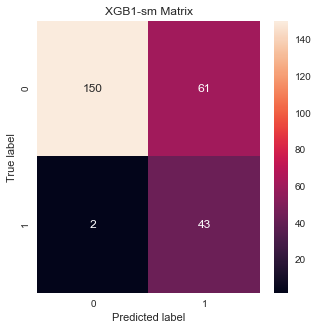

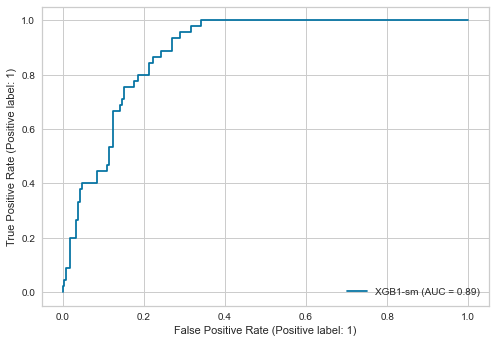

In [137]:
#Evaluating the model performance
print('Xgboost classifier trained on generated data without hyperparameter tuning')
create_results(y_test, prediction2)
plot_cm(y_test, prediction2, name='XGB1-sm Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb, X_test, y_test, name='XGB1-sm')

In [140]:
#addiing feature_importance
feature_importances(xgb, ax=axs[0,0], X=X_sm, y=y_sm, topn=10)
axs[0, 0].set_title('XGB1-Sm', fontsize=20)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'XGB1-Sm')

In [141]:
#Fitting the Xgb model on the generated data and testing on test set without hyperparameter tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_sm2, y_sm2)
cross_score_2a = cross_val_score(xgb, X_sm2, y_sm2, cv=cv_split, scoring='f1_macro')
prediction2a=xgb.predict(X_test)

Xgboost classifier trained on bsm generated data without hyperparameter tuning

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       211
           1       0.44      0.91      0.59        45

    accuracy                           0.78       256
   macro avg       0.71      0.83      0.72       256
weighted avg       0.88      0.78      0.80       256


[[158  53]
 [  4  41]]

Healthy Individuals Detected (True Negatives):  158
Healthy Individuals Incorrectly Detected (False Positives):  53
Covid-19 Patients not detected  (False Negatives):  4
Covid-19 Patients Detected (True Positives):  41
Total Covid-19 Patients in Data:  45

Specificity :  0.7488151658767772
Sensitivity :  0.9111111111111111
Precision :  0.43617021276595747
F1-Score :  0.5899280575539568

Roc curve on test set: 


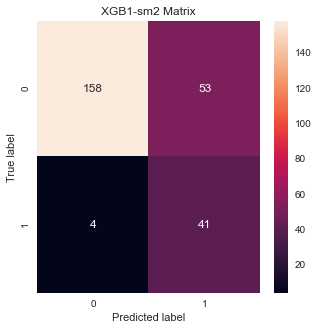

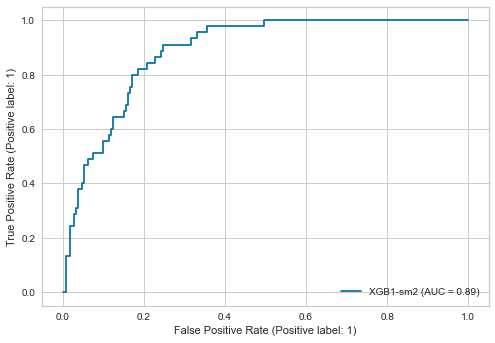

In [142]:
#Evaluating the model performance
print('Xgboost classifier trained on bsm generated data without hyperparameter tuning')
create_results(y_test, prediction2a)
plot_cm(y_test, prediction2a, name='XGB1-sm2 Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb, X_test, y_test, name='XGB1-sm2')

In [143]:
#addiing feature_importance
feature_importances(xgb, ax=axs[0,1], X=X_sm2, y=y_sm2, topn=10)
axs[0, 1].set_title('XGB1-Sm2', fontsize=20)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'XGB1-Sm2')

In [72]:
#Fitting the Xgb model on the generated data and testing on test set without hyperparameter tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_bsm, y_bsm)
cross_score_2b = cross_val_score(xgb, X_bsm, y_bsm, cv=cv_split, scoring='f1_macro')
prediction2b=xgb.predict(X_test)

Xgboost classifier trained on bsm generated data without hyperparameter tuning

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       211
           1       0.42      0.82      0.56        45

    accuracy                           0.77       256
   macro avg       0.69      0.79      0.70       256
weighted avg       0.86      0.77      0.79       256


[[160  51]
 [  8  37]]

Healthy Individuals Detected (True Negatives):  160
Healthy Individuals Incorrectly Detected (False Positives):  51
Covid-19 Patients not detected  (False Negatives):  8
Covid-19 Patients Detected (True Positives):  37
Total Covid-19 Patients in Data:  45

Specificity :  0.7582938388625592
Sensitivity :  0.8222222222222222
Precision :  0.42045454545454547
F1-Score :  0.556390977443609

Roc curve on test set: 


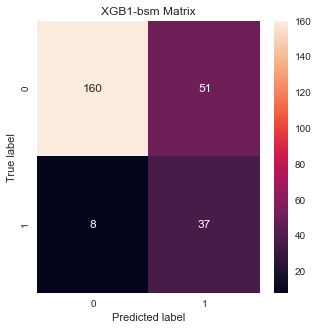

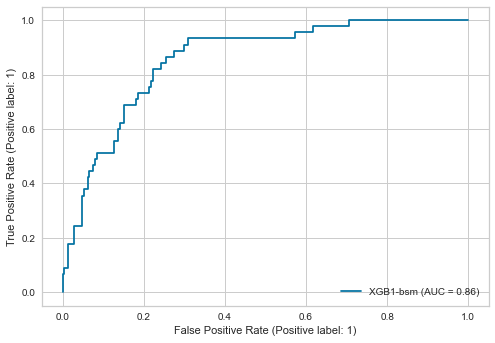

In [73]:
#Evaluating the model performance
print('Xgboost classifier trained on bsm generated data without hyperparameter tuning')
create_results(y_test, prediction2b)
plot_cm(y_test, prediction2b, name='XGB1-bsm Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb, X_test, y_test, name='XGB1-bsm')

In [74]:
#Fitting the Xgb model on the generated data and testing on test set without hyperparameter tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_ada, y_ada)
cross_score_2c = cross_val_score(xgb, X_ada, y_ada, cv=cv_split, scoring='f1_macro')
prediction2c=xgb.predict(X_test)

Xgboost classifier trained on adasyn generated data without hyperparameter tuning

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       211
           1       0.39      0.84      0.53        45

    accuracy                           0.74       256
   macro avg       0.67      0.78      0.67       256
weighted avg       0.86      0.74      0.77       256


[[151  60]
 [  7  38]]

Healthy Individuals Detected (True Negatives):  151
Healthy Individuals Incorrectly Detected (False Positives):  60
Covid-19 Patients not detected  (False Negatives):  7
Covid-19 Patients Detected (True Positives):  38
Total Covid-19 Patients in Data:  45

Specificity :  0.7156398104265402
Sensitivity :  0.8444444444444444
Precision :  0.3877551020408163
F1-Score :  0.5314685314685315

Roc curve on test set: 


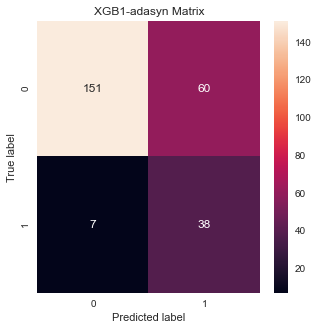

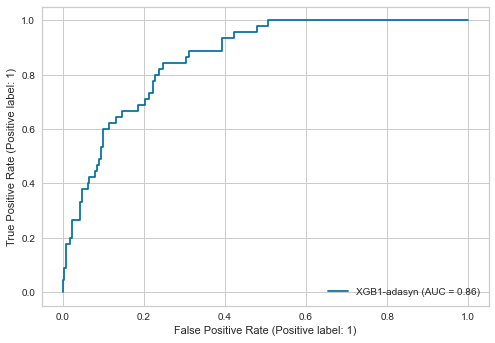

In [75]:
#Evaluating the model performance
print('Xgboost classifier trained on adasyn generated data without hyperparameter tuning')
create_results(y_test, prediction2c)
plot_cm(y_test, prediction2c, name='XGB1-adasyn Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb, X_test, y_test, name='XGB1-adasyn')

In [58]:
#Fitting the Xgb model on the generated data and testing on test set without hyperparameter tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_rnd, y_rnd)
cross_score_2d = cross_val_score(xgb, X_rnd, y_rnd, cv=cv_split, scoring='f1_macro')
prediction2d=xgb.predict(X_test)

Xgboost classifier trained on rnd generated data without hyperparameter tuning

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       211
           1       0.40      0.87      0.55        45

    accuracy                           0.75       256
   macro avg       0.68      0.79      0.68       256
weighted avg       0.86      0.75      0.77       256


[[152  59]
 [  6  39]]

Healthy Individuals Detected (True Negatives):  152
Healthy Individuals Incorrectly Detected (False Positives):  59
Covid-19 Patients not detected  (False Negatives):  6
Covid-19 Patients Detected (True Positives):  39
Total Covid-19 Patients in Data:  45

Specificity :  0.7203791469194313
Sensitivity :  0.8666666666666667
Precision :  0.3979591836734694
F1-Score :  0.5454545454545454

Roc curve on test set: 


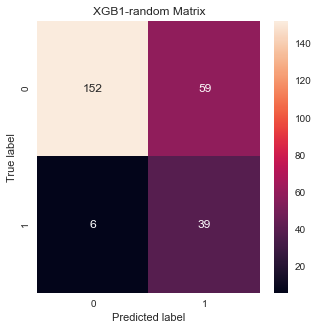

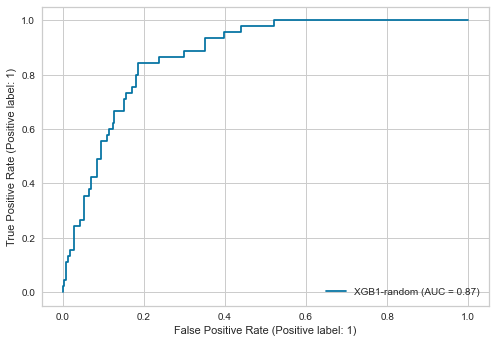

In [59]:
#Evaluating the model performance
print('Xgboost classifier trained on rnd generated data without hyperparameter tuning')
create_results(y_test, prediction2d)
plot_cm(y_test, prediction2d, name='XGB1-random Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb, X_test, y_test, name='XGB1-random')

In [460]:
scorers = {
    'auc_score': make_scorer(auc),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

In [461]:
##Hyperparameter tuning for xgb

# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(100, 1500, 10)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(10, 100, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 25, 10)]

# Adding regularizer
xgb_lambda = [int(x) for x in np.linspace(0, 1, 3)]

xgb_alpha = [int(x) for x in np.linspace(0, 1, 3)]

# Penalty for miss classifying PCR confirmed patients
'''
sum(negative instances) / sum(positive instances) 
#'scale_pos_weight': xgb_scale_pos_weight,
'''
xgb_scale_pos_weight = [1,1.2,1.6,2]

# Learning rate
xgb_eta = [x for x in np.linspace(0.01, 0.5, 10)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 5, 10)]

# Learning objective used
xgb_objective = ['binary:logistic']

# Tree method
xgb_tree_method = ['hist']

num_class = [1]

# Create the grid
xgb_param = {'n_estimators': xgb_n_estimators,
             'max_depth': xgb_max_depth,
             'min_child_weight': xgb_min_child_weight,
             'eta': xgb_eta,
             'gamma': xgb_gamma,
             'scale_pos_weight': xgb_scale_pos_weight,
             'objective': xgb_objective,
             'num_class': num_class,
             'alpha':xgb_alpha,
             'lambda':xgb_lambda,
             'tree_method':xgb_tree_method}

In [25]:
#Creating instance of RepeatedStratifiedKFold to run Cross validation with training data
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=5)
xgb3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# Create the random search for hyperparameter search
xgb_random = RandomizedSearchCV(estimator=xgb3, param_distributions=xgb_param,
                                n_iter=200, cv=cv, refit='f1_score',scoring=scorers, verbose=2,
                                random_state=7)



In [26]:
search=xgb_random.fit(X_sm, y_sm)
# Get the optimal parameters
best_parameter=search.best_params_
print(best_parameter)
cross_score_3 = search.best_score_


Fitting 20 folds for each of 200 candidates, totalling 4000 fits
[CV] END alpha=0, eta=0.22777777777777777, gamma=4, lambda=1, max_depth=50, min_child_weight=19, n_estimators=877, num_class=1, objective=binary:logistic, scale_pos_weight=2, tree_method=hist; total time=   0.9s
[CV] END alpha=0, eta=0.22777777777777777, gamma=4, lambda=1, max_depth=50, min_child_weight=19, n_estimators=877, num_class=1, objective=binary:logistic, scale_pos_weight=2, tree_method=hist; total time=   0.8s
[CV] END alpha=0, eta=0.22777777777777777, gamma=4, lambda=1, max_depth=50, min_child_weight=19, n_estimators=877, num_class=1, objective=binary:logistic, scale_pos_weight=2, tree_method=hist; total time=   0.8s
[CV] END alpha=0, eta=0.22777777777777777, gamma=4, lambda=1, max_depth=50, min_child_weight=19, n_estimators=877, num_class=1, objective=binary:logistic, scale_pos_weight=2, tree_method=hist; total time=   0.7s
[CV] END alpha=0, eta=0.22777777777777777, gamma=4, lambda=1, max_depth=50, min_child_w

In [27]:
search.best_params_, search.best_score_


({'tree_method': 'hist',
  'scale_pos_weight': 1.6,
  'objective': 'binary:logistic',
  'num_class': 1,
  'n_estimators': 877,
  'min_child_weight': 6,
  'max_depth': 10,
  'lambda': 1,
  'gamma': 2,
  'eta': 0.11888888888888888,
  'alpha': 1},
 0.89867083071832)

In [165]:
xgb4 = XGBClassifier(tree_method='hist', scale_pos_weight=1.6, objective='binary:logistic', num_class=1,
                     use_label_encoder=False, eval_metric='logloss', n_estimators=877, min_child_weight=6, 
                    max_depth=10, reg_lambda=1, gamma=2, eta=0.1, alpha=1)
xgb4.fit(X_sm, y_sm)
cross_score_3 = cross_val_score(xgb4, X_sm, y_sm, cv=cv_split, scoring='f1_macro')
prediction4=xgb4.predict(X_test)

Xgboost classifier trained on generated data and hyperparameter tuned with Randomsearch to optimise f1-score

XGBClassifier: 

              precision    recall  f1-score   support

           0       1.00      0.63      0.77       211
           1       0.37      1.00      0.54        45

    accuracy                           0.70       256
   macro avg       0.68      0.82      0.65       256
weighted avg       0.89      0.70      0.73       256


[[133  78]
 [  0  45]]

Healthy Individuals Detected (True Negatives):  133
Healthy Individuals Incorrectly Detected (False Positives):  78
Covid-19 Patients not detected  (False Negatives):  0
Covid-19 Patients Detected (True Positives):  45
Total Covid-19 Patients in Data:  45

Specificity :  0.6303317535545023
Sensitivity :  1.0
Precision :  0.36585365853658536
F1-Score :  0.5357142857142857

Roc curve on test set: 


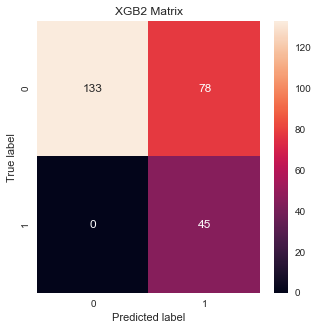

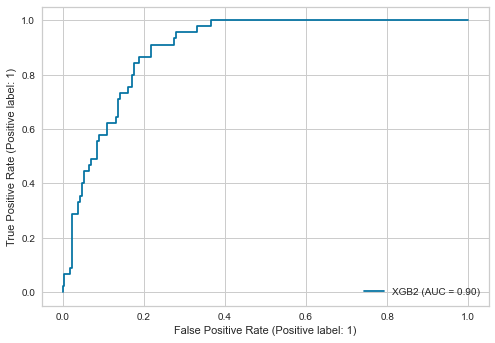

In [166]:
#Evaluating the model performance
print('Xgboost classifier trained on generated data and hyperparameter tuned with Randomsearch to optimise f1-score')
create_results(y_test, prediction4)
plot_cm(y_test, prediction4, name='XGB2 Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb4, X_test, y_test, name='XGB2')


In [167]:
#addiing feature_importance
feature_importances(xgb4, ax=axs[1,0], X=X_sm, y=y_sm, topn=10)
axs[1, 0].set_title('XGB2-Sm', fontsize=20)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'XGB2-Sm')

In [144]:
xgb6 = XGBClassifier(use_label_encoder=False, eval_metric='logloss',tree_method= 'hist', scale_pos_weight=1.6, 
                    objective= 'binary:logistic', num_class= 1, n_estimators= 1000, min_child_weight=6, 
                    max_depth= 30, reg_lambda=1, gamma = 1, eta =0.01, alpha=1)
xgb6.fit(X_sm, y_sm)
cross_score_4 = cross_val_score(xgb6, X_sm, y_sm, cv=cv_split, scoring='f1_macro')
prediction5=xgb6.predict(X_test)

Xgboost classifier trained on generated data and hyperparameter chosen based on data heuristics

XGBClassifier: 

              precision    recall  f1-score   support

           0       1.00      0.64      0.78       211
           1       0.37      1.00      0.54        45

    accuracy                           0.70       256
   macro avg       0.68      0.82      0.66       256
weighted avg       0.89      0.70      0.73       256


[[134  77]
 [  0  45]]

Healthy Individuals Detected (True Negatives):  134
Healthy Individuals Incorrectly Detected (False Positives):  77
Covid-19 Patients not detected  (False Negatives):  0
Covid-19 Patients Detected (True Positives):  45
Total Covid-19 Patients in Data:  45

Specificity :  0.6350710900473934
Sensitivity :  1.0
Precision :  0.36885245901639346
F1-Score :  0.5389221556886228

Roc curve on test set: 


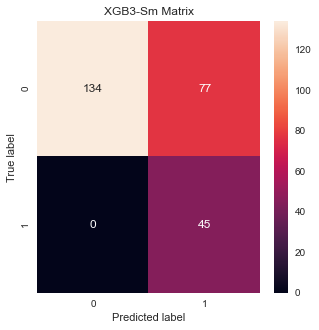

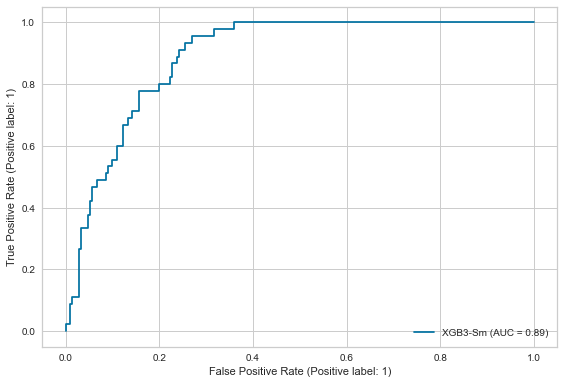

Text(0.5, 1.0, 'XGB3-Sm')

In [145]:
#Evaluating the model performance
print('Xgboost classifier trained on generated data and hyperparameter chosen based on data heuristics')
create_results(y_test, prediction5)
plot_cm(y_test, prediction5, name='XGB3-Sm Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb6, X_test, y_test, name='XGB3-Sm')

#addiing feature_importance
feature_importances(xgb6, ax=axs[2,0], X=X_sm, y=y_sm, topn=10)
axs[2, 0].set_title('XGB3-Sm', fontsize=20)


In [168]:
#Fitting the model hyperparameter tuned, using randomsearch, on 2nd generated data
xgb4.fit(X_sm2, y_sm2)
cross_score_5 = cross_val_score(xgb4, X_sm2, y_sm2, cv=cv_split, scoring='f1_macro')
prediction6= xgb4.predict(X_test)

Xgboost classifier hyperparameter as xgb4 and trained on 2nd generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       211
           1       0.41      0.98      0.58        45

    accuracy                           0.75       256
   macro avg       0.70      0.84      0.70       256
weighted avg       0.89      0.75      0.78       256


[[147  64]
 [  1  44]]

Healthy Individuals Detected (True Negatives):  147
Healthy Individuals Incorrectly Detected (False Positives):  64
Covid-19 Patients not detected  (False Negatives):  1
Covid-19 Patients Detected (True Positives):  44
Total Covid-19 Patients in Data:  45

Specificity :  0.6966824644549763
Sensitivity :  0.9777777777777777
Precision :  0.4074074074074074
F1-Score :  0.5751633986928104

Roc curve on test set: 


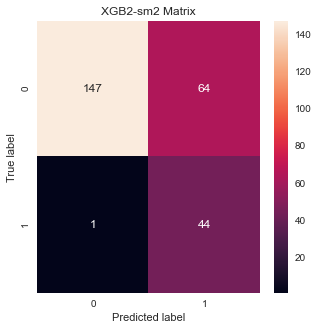

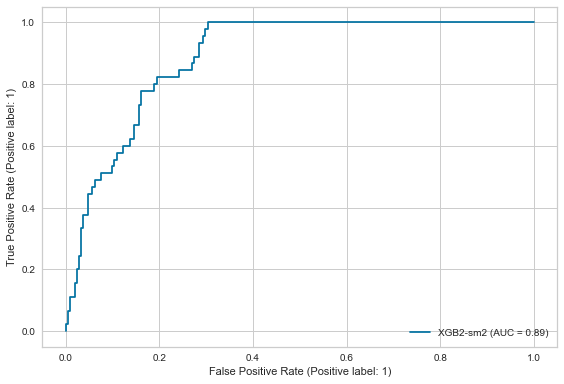

Text(0.5, 1.0, 'XGB2-Sm2')

In [169]:
#Evaluating the model performance
print('Xgboost classifier hyperparameter as xgb4 and trained on 2nd generated data and tested on X_test')
create_results(y_test, prediction6)
plot_cm(y_test, prediction6, name='XGB2-sm2 Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb4, X_test, y_test, name='XGB2-sm2')

#addiing feature_importance
feature_importances(xgb4, ax=axs[1,1], X=X_sm2, y=y_sm2, topn=10)
axs[1, 1].set_title('XGB2-Sm2', fontsize=20)


In [395]:
xgb6.fit(X_sm2, y_sm2)
cross_score_6 = cross_val_score(xgb6, X_sm2, y_sm2, cv=cv_split, scoring='f1_macro')
prediction7= xgb6.predict(X_test)

Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on 2nd generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.99      0.69      0.82       211
           1       0.40      0.98      0.57        45

    accuracy                           0.74       256
   macro avg       0.70      0.83      0.69       256
weighted avg       0.89      0.74      0.77       256


[[146  65]
 [  1  44]]

Healthy Individuals Detected (True Negatives):  146
Healthy Individuals Incorrectly Detected (False Positives):  65
Covid-19 Patients not detected  (False Negatives):  1
Covid-19 Patients Detected (True Positives):  44
Total Covid-19 Patients in Data:  45

Specificity :  0.6919431279620853
Sensitivity :  0.9777777777777777
Precision :  0.4036697247706422
F1-Score :  0.5714285714285714

Roc curve on test set: 


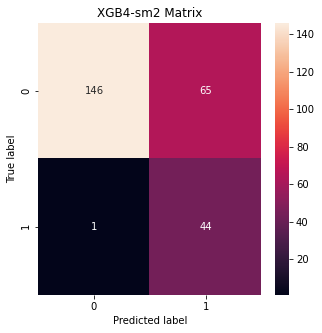

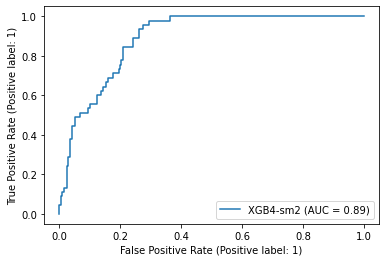

In [396]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on 2nd generated data and tested on X_test')
create_results(y_test, prediction7)
plot_cm(y_test, prediction7, name='XGB4-sm2 Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb6, X_test, y_test, name='XGB4-sm2')

In [82]:
#Fitting XGB3 with BSM and testing on X_test
#Fitting the model hyperparameter tuned, using randomsearch, on BSM generated data
xgb4.fit(X_bsm, y_bsm)
cross_score_7 = cross_val_score(xgb4, X_bsm, y_bsm, cv=cv_split, scoring='f1_macro')
prediction8= xgb4.predict(X_test)

Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on BSM generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.96      0.70      0.81       211
           1       0.38      0.87      0.53        45

    accuracy                           0.73       256
   macro avg       0.67      0.78      0.67       256
weighted avg       0.86      0.73      0.76       256


[[147  64]
 [  6  39]]

Healthy Individuals Detected (True Negatives):  147
Healthy Individuals Incorrectly Detected (False Positives):  64
Covid-19 Patients not detected  (False Negatives):  6
Covid-19 Patients Detected (True Positives):  39
Total Covid-19 Patients in Data:  45

Specificity :  0.6966824644549763
Sensitivity :  0.8666666666666667
Precision :  0.3786407766990291
F1-Score :  0.527027027027027

Roc curve on test set: 


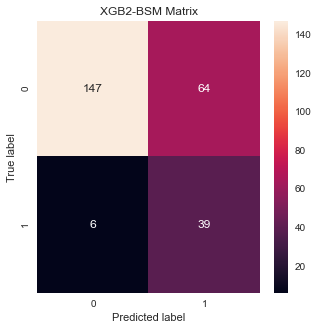

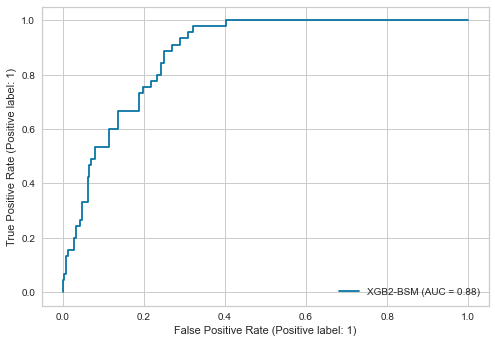

In [97]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on BSM generated data and tested on X_test')
create_results(y_test, prediction8)
plot_cm(y_test, prediction8, name='XGB2-BSM Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb4, X_test, y_test, name='XGB2-BSM')

In [84]:
#Fitting XGB4 with BSM and testing on X_test
#Fitting the model hyperparameter tuned, using randomsearch, on BSM generated data
xgb6.fit(X_bsm, y_bsm)
cross_score_8 = cross_val_score(xgb6, X_bsm, y_bsm, cv=cv_split, scoring='f1_macro')
prediction9= xgb6.predict(X_test)

Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on BSM generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.72      0.83       211
           1       0.41      0.91      0.57        45

    accuracy                           0.75       256
   macro avg       0.69      0.82      0.70       256
weighted avg       0.88      0.75      0.78       256


[[152  59]
 [  4  41]]

Healthy Individuals Detected (True Negatives):  152
Healthy Individuals Incorrectly Detected (False Positives):  59
Covid-19 Patients not detected  (False Negatives):  4
Covid-19 Patients Detected (True Positives):  41
Total Covid-19 Patients in Data:  45

Specificity :  0.7203791469194313
Sensitivity :  0.9111111111111111
Precision :  0.41
F1-Score :  0.5655172413793104

Roc curve on test set: 


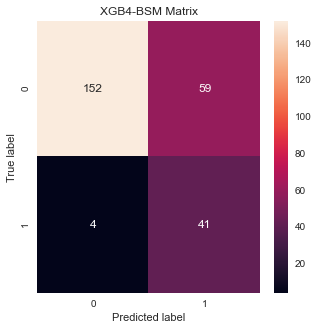

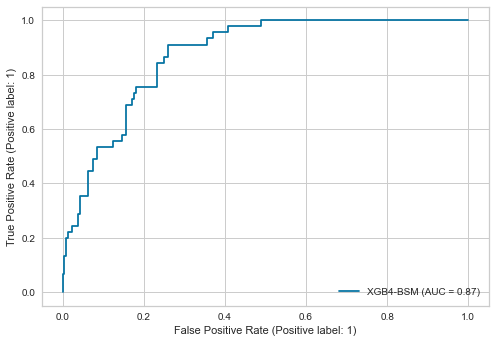

In [85]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on BSM generated data and tested on X_test')
create_results(y_test, prediction9)
plot_cm(y_test, prediction9, name='XGB3-BSM Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb6, X_test, y_test, name='XGB3-BSM')

In [100]:
#Fitting XGB3 with BSM and testing on X_test
#Fitting the model hyperparameter tuned, using randomsearch, on BSM generated data
xgb4.fit(X_ada, y_ada)
cross_score_9 = cross_val_score(xgb4, X_ada, y_ada, cv=cv_split, scoring='f1_macro')
prediction10= xgb4.predict(X_test)

Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on ADA generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       211
           1       0.40      0.93      0.56        45

    accuracy                           0.74       256
   macro avg       0.69      0.82      0.69       256
weighted avg       0.88      0.74      0.77       256


[[148  63]
 [  3  42]]

Healthy Individuals Detected (True Negatives):  148
Healthy Individuals Incorrectly Detected (False Positives):  63
Covid-19 Patients not detected  (False Negatives):  3
Covid-19 Patients Detected (True Positives):  42
Total Covid-19 Patients in Data:  45

Specificity :  0.7014218009478673
Sensitivity :  0.9333333333333333
Precision :  0.4
F1-Score :  0.56

Roc curve on test set: 


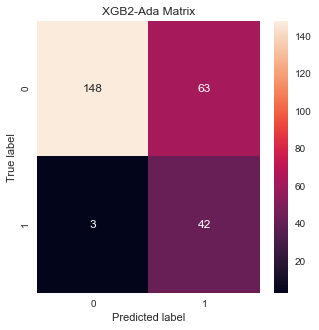

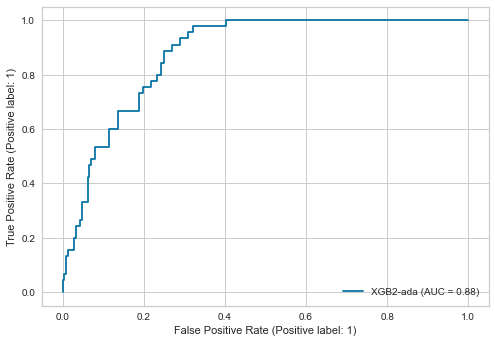

In [101]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on ADA generated data and tested on X_test')
create_results(y_test, prediction10)
plot_cm(y_test, prediction10, name='XGB2-Ada Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb4, X_test, y_test, name='XGB2-ada')

In [385]:
#Fitting XGB4 with Ada and testing on X_test
xgb6.fit(X_ada, y_ada)
cross_score_10 = cross_val_score(xgb6, X_ada, y_ada, cv=cv_split, scoring='f1_macro')
prediction11= xgb6.predict(X_test)

Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on Ada generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.99      0.66      0.79       211
           1       0.38      0.96      0.54        45

    accuracy                           0.71       256
   macro avg       0.68      0.81      0.67       256
weighted avg       0.88      0.71      0.75       256


[[140  71]
 [  2  43]]

Healthy Individuals Detected (True Negatives):  140
Healthy Individuals Incorrectly Detected (False Positives):  71
Covid-19 Patients not detected  (False Negatives):  2
Covid-19 Patients Detected (True Positives):  43
Total Covid-19 Patients in Data:  45

Specificity :  0.6635071090047393
Sensitivity :  0.9555555555555556
Precision :  0.37719298245614036
F1-Score :  0.5408805031446541

Roc curve on test set: 


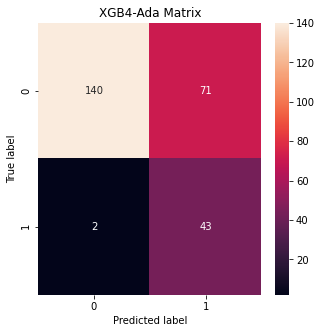

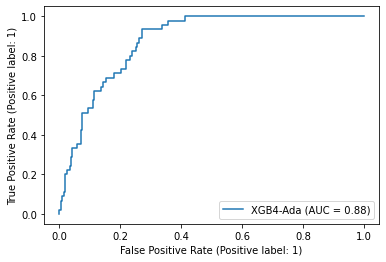

In [387]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on Ada generated data and tested on X_test')
create_results(y_test, prediction11)
plot_cm(y_test, prediction11, name='XGB3-Ada Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb6, X_test, y_test, name='XGB3-Ada')

In [389]:
#Fitting XGB3 with RND and testing on X_test
xgb4.fit(X_rnd, y_rnd)
cross_score_11= cross_val_score(xgb4, X_rnd, y_rnd, cv=cv_split, scoring='f1_macro')
prediction12= xgb4.predict(X_test)

Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on Random generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       211
           1       0.41      0.98      0.58        45

    accuracy                           0.75       256
   macro avg       0.70      0.84      0.70       256
weighted avg       0.89      0.75      0.78       256


[[148  63]
 [  1  44]]

Healthy Individuals Detected (True Negatives):  148
Healthy Individuals Incorrectly Detected (False Positives):  63
Covid-19 Patients not detected  (False Negatives):  1
Covid-19 Patients Detected (True Positives):  44
Total Covid-19 Patients in Data:  45

Specificity :  0.7014218009478673
Sensitivity :  0.9777777777777777
Precision :  0.411214953271028
F1-Score :  0.5789473684210527

Roc curve on test set: 


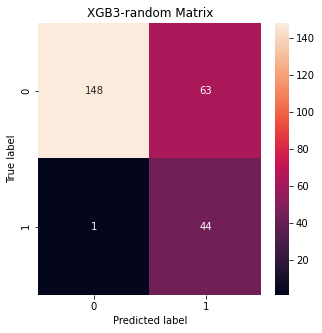

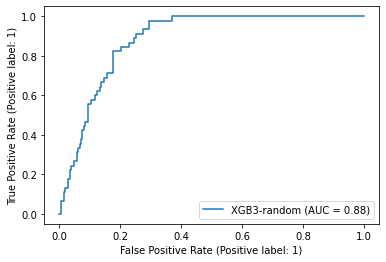

In [390]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on Random generated data and tested on X_test')
create_results(y_test, prediction12)
plot_cm(y_test, prediction12, name='XGB2-random Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb4, X_test, y_test, name='XGB2-random')

In [149]:
#Fitting XGB4 with Ada and testing on X_test
xgb6.fit(X_rnd, y_rnd)
cross_score_12 = cross_val_score(xgb6, X_rnd, y_rnd, cv=cv_split, scoring='f1_macro')
prediction13= xgb6.predict(X_test)

Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on raondom generated data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       211
           1       0.42      0.96      0.58        45

    accuracy                           0.76       256
   macro avg       0.70      0.84      0.71       256
weighted avg       0.89      0.76      0.79       256


[[151  60]
 [  2  43]]

Healthy Individuals Detected (True Negatives):  151
Healthy Individuals Incorrectly Detected (False Positives):  60
Covid-19 Patients not detected  (False Negatives):  2
Covid-19 Patients Detected (True Positives):  43
Total Covid-19 Patients in Data:  45

Specificity :  0.7156398104265402
Sensitivity :  0.9555555555555556
Precision :  0.4174757281553398
F1-Score :  0.581081081081081

Roc curve on test set: 


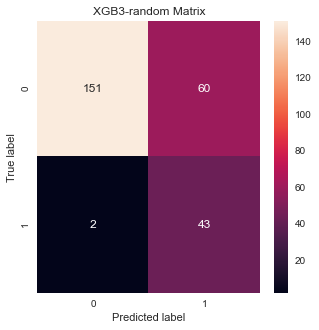

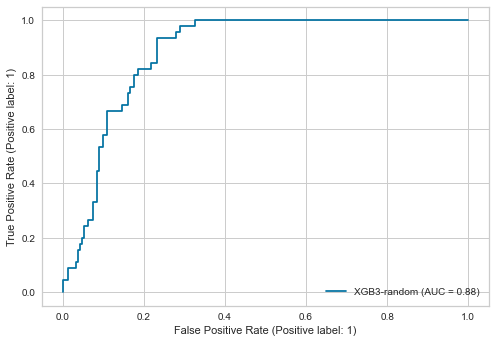

In [150]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter from learned heuristics of data as xgb6 and trained on raondom generated data and tested on X_test')
create_results(y_test, prediction13)
plot_cm(y_test, prediction13, name='XGB3-random Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb6, X_test, y_test, name='XGB3-random')



In [151]:
#addiing feature_importance
feature_importances(xgb6, ax=axs[2,1], X=X_rnd, y=y_rnd, topn=10)
axs[2, 1].set_title('XGB3-Random', fontsize=20)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'XGB3-Random')

In [405]:
#Hyper parameter grid for AdaBoost 
ada_n_estimators = [50, 100, 500, 800]
ada_learn_rate = [0.001, 0.01, 0.1, 1.0]
ada_grid = {'n_estimators': ada_n_estimators,
           'learning_rate': ada_learn_rate}

In [406]:
#Fitting Ada Boost to the Dataset 

ada_model = AdaBoostClassifier(random_state=21)
grid_search = GridSearchCV(estimator=ada_model, param_grid=ada_grid, n_jobs=-1, cv=cv_split, scoring='f1_macro')

In [407]:
grid_result = grid_search.fit(X_sm, y_sm)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Best: 0.904002 using {'learning_rate': 0.1, 'n_estimators': 500}
0.839259 (0.005095) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.846579 (0.015929) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.876603 (0.008995) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.881359 (0.009901) with: {'learning_rate': 0.001, 'n_estimators': 800}
0.876466 (0.008748) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.884894 (0.008943) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.899050 (0.005409) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.901384 (0.005201) with: {'learning_rate': 0.01, 'n_estimators': 800}
0.899212 (0.005662) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.902672 (0.005272) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.904002 (0.006367) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.903955 (0.006633) with: {'learning_rate': 0.1, 'n_estimators': 800}
0.902205 (0.006932) with: {'learning_rate': 1.0, 'n_estimators': 50}
0.902241 (0.00688

In [458]:
#Fitting Ada and testing on X_test
ada_model = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=21)
ada_model.fit(doc_features, doc_labels)
cross_score_ada = cross_val_score(ada_model, doc_features, doc_labels.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction_ada= ada_model.predict(X_test)

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AdaBoost classifier with hyperparameter from Grid Search on imbalanced data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       211
           1       0.58      0.56      0.57        45

    accuracy                           0.85       256
   macro avg       0.74      0.74      0.74       256
weighted avg       0.85      0.85      0.85       256


[[193  18]
 [ 20  25]]

Healthy Individuals Detected (True Negatives):  193
Healthy Individuals Incorrectly Detected (False Positives):  18
Covid-19 Patients not detected  (False Negatives):  20
Covid-19 Patients Detected (True Positives):  25
Total Covid-19 Patients in Data:  45

Specificity :  0.9146919431279621
Sensitivity :  0.5555555555555556
Precision :  0.5813953488372093
F1-Score :  0.5681818181818182

Roc curve on test set: 


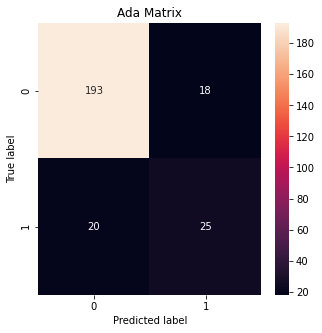

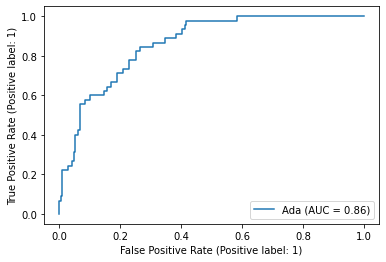

In [459]:
#Evaluating the model performance
print('AdaBoost classifier with hyperparameter from Grid Search on imbalanced data and tested on X_test')
create_results(y_test, prediction_ada)
plot_cm(y_test, prediction_ada, name='Ada Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(ada_model, X_test, y_test, name='Ada')

In [414]:
#Fitting Ada and testing on X_test
ada_model = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=21)
ada_model.fit(X_sm, y_sm)
cross_score_13 = cross_val_score(ada_model, X_sm, y_sm.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction14= ada_model.predict(X_test)

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AdaBoost classifier with hyperparameter from Grid Search on X_sm data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.65      0.78       211
           1       0.36      0.91      0.52        45

    accuracy                           0.70       256
   macro avg       0.67      0.78      0.65       256
weighted avg       0.86      0.70      0.74       256


[[138  73]
 [  4  41]]

Healthy Individuals Detected (True Negatives):  138
Healthy Individuals Incorrectly Detected (False Positives):  73
Covid-19 Patients not detected  (False Negatives):  4
Covid-19 Patients Detected (True Positives):  41
Total Covid-19 Patients in Data:  45

Specificity :  0.6540284360189573
Sensitivity :  0.9111111111111111
Precision :  0.35964912280701755
F1-Score :  0.5157232704402516

Roc curve on test set: 


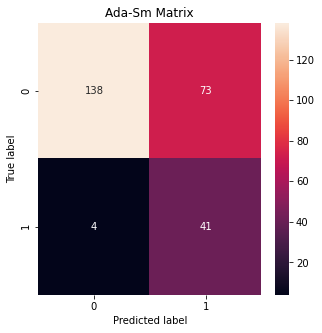

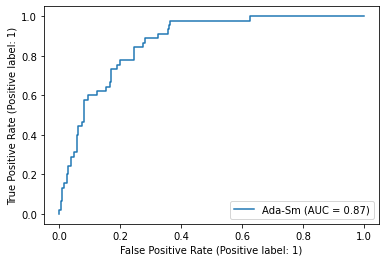

In [415]:
#Evaluating the model performance
print('AdaBoost classifier with hyperparameter from Grid Search on X_sm data and tested on X_test')
create_results(y_test, prediction14)
plot_cm(y_test, prediction14, name='Ada-Sm Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(ada_model, X_test, y_test, name='Ada-Sm')

In [416]:
#Fitting Ada and testing on X_test
ada_model = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=21)
ada_model.fit(X_sm2, y_sm2)
cross_score_14 = cross_val_score(ada_model, X_sm2, y_sm2.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction15= ada_model.predict(X_test)

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AdaBoost classifier with hyperparameter from Grid Search on X_sm2 data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       211
           1       0.39      0.87      0.54        45

    accuracy                           0.74       256
   macro avg       0.68      0.79      0.68       256
weighted avg       0.86      0.74      0.77       256


[[151  60]
 [  6  39]]

Healthy Individuals Detected (True Negatives):  151
Healthy Individuals Incorrectly Detected (False Positives):  60
Covid-19 Patients not detected  (False Negatives):  6
Covid-19 Patients Detected (True Positives):  39
Total Covid-19 Patients in Data:  45

Specificity :  0.7156398104265402
Sensitivity :  0.8666666666666667
Precision :  0.3939393939393939
F1-Score :  0.5416666666666666

Roc curve on test set: 


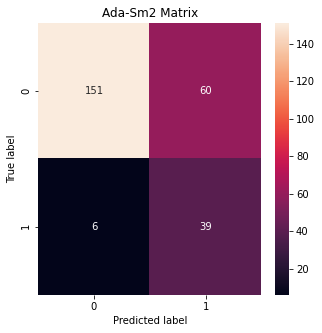

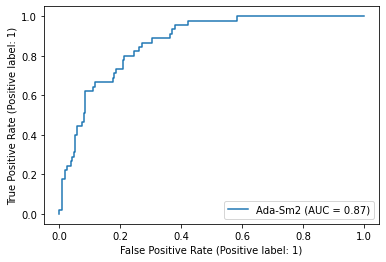

In [417]:
#Evaluating the model performance
print('AdaBoost classifier with hyperparameter from Grid Search on X_sm2 data and tested on X_test')
create_results(y_test, prediction15)
plot_cm(y_test, prediction15, name='Ada-Sm2 Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(ada_model, X_test, y_test, name='Ada-Sm2')

In [155]:
#Fitting Ada and testing on X_test
ada_model = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=21)
ada_model.fit(X_bsm, y_bsm)
cross_score_15 = cross_val_score(ada_model, X_bsm, y_bsm.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction16= ada_model.predict(X_test)

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AdaBoost classifier, with hyperparameter from Grid Search, on X_bsm data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.72      0.83       211
           1       0.41      0.91      0.57        45

    accuracy                           0.75       256
   macro avg       0.69      0.82      0.70       256
weighted avg       0.88      0.75      0.78       256


[[152  59]
 [  4  41]]

Healthy Individuals Detected (True Negatives):  152
Healthy Individuals Incorrectly Detected (False Positives):  59
Covid-19 Patients not detected  (False Negatives):  4
Covid-19 Patients Detected (True Positives):  41
Total Covid-19 Patients in Data:  45

Specificity :  0.7203791469194313
Sensitivity :  0.9111111111111111
Precision :  0.41
F1-Score :  0.5655172413793104

Roc curve on test set: 


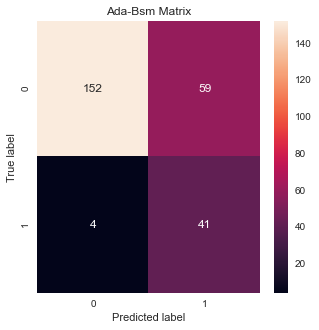

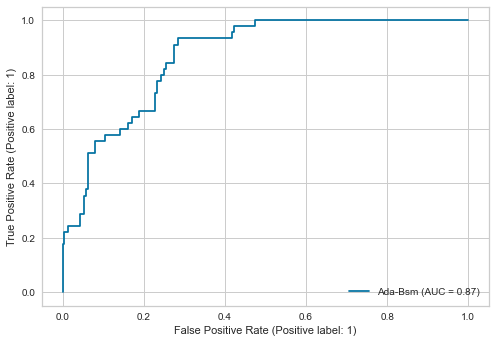

In [156]:
#Evaluating the model performance
print('AdaBoost classifier, with hyperparameter from Grid Search, on X_bsm data and tested on X_test')
create_results(y_test, prediction16)
plot_cm(y_test, prediction16, name='Ada-Bsm Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(ada_model, X_test, y_test, name='Ada-Bsm')

#feature_importances(estimator=ada_model, X=X_bsm, y=y_bsm, ax=axs[0,1], topn=10)


In [157]:
#addiing feature_importance
feature_importances(ada_model, ax=axs[3,1], X=X_bsm, y=y_bsm, topn=10)
axs[3, 1].set_title('Ada-Bsm', fontsize=20)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Ada-Bsm')

In [152]:
#Fitting Ada and testing on X_test
ada_model = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=21)
ada_model.fit(X_ada, y_ada)
cross_score_16 = cross_val_score(ada_model, X_ada, y_ada.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction17 = ada_model.predict(X_test)

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AdaBoost classifier with hyperparameter from Grid Search on X_ada data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.73      0.83       211
           1       0.41      0.91      0.57        45

    accuracy                           0.76       256
   macro avg       0.69      0.82      0.70       256
weighted avg       0.88      0.76      0.79       256


[[153  58]
 [  4  41]]

Healthy Individuals Detected (True Negatives):  153
Healthy Individuals Incorrectly Detected (False Positives):  58
Covid-19 Patients not detected  (False Negatives):  4
Covid-19 Patients Detected (True Positives):  41
Total Covid-19 Patients in Data:  45

Specificity :  0.7251184834123223
Sensitivity :  0.9111111111111111
Precision :  0.41414141414141414
F1-Score :  0.5694444444444444

Roc curve on test set: 


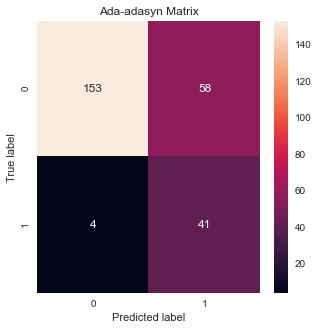

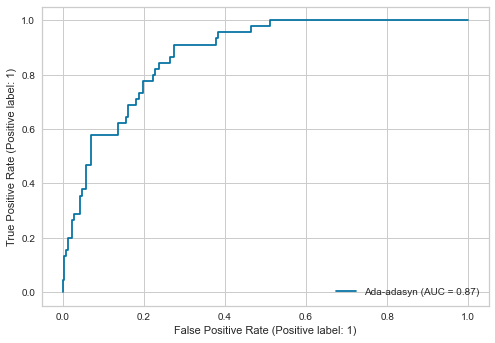

In [153]:
#Evaluating the model performance
print('AdaBoost classifier with hyperparameter from Grid Search on X_ada data and tested on X_test')
create_results(y_test, prediction17)
plot_cm(y_test, prediction17, name='Ada-adasyn Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(ada_model, X_test, y_test, name='Ada-adasyn')

In [154]:
#addiing feature_importance
feature_importances(ada_model, ax=axs[3,0], X=X_ada, y=y_ada, topn=10)
axs[3, 0].set_title('Ada-Adasyn', fontsize=20)

<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Ada-Adasyn')

In [424]:
#Fitting Ada and testing on X_test
ada_model = AdaBoostClassifier(n_estimators=500, learning_rate=0.1, random_state=21)
ada_model.fit(X_rnd, y_rnd)
cross_score_17 = cross_val_score(ada_model, X_rnd, y_rnd.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction18 = ada_model.predict(X_test)

/Users/mashrurhaidernew/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


AdaBoost classifier with hyperparameter from Grid Search on X_rnd data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.66      0.79       211
           1       0.37      0.91      0.52        45

    accuracy                           0.71       256
   macro avg       0.67      0.79      0.66       256
weighted avg       0.87      0.71      0.74       256


[[140  71]
 [  4  41]]

Healthy Individuals Detected (True Negatives):  140
Healthy Individuals Incorrectly Detected (False Positives):  71
Covid-19 Patients not detected  (False Negatives):  4
Covid-19 Patients Detected (True Positives):  41
Total Covid-19 Patients in Data:  45

Specificity :  0.6635071090047393
Sensitivity :  0.9111111111111111
Precision :  0.36607142857142855
F1-Score :  0.5222929936305732

Roc curve on test set: 


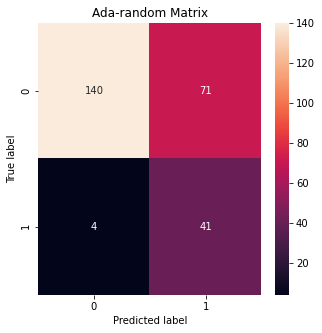

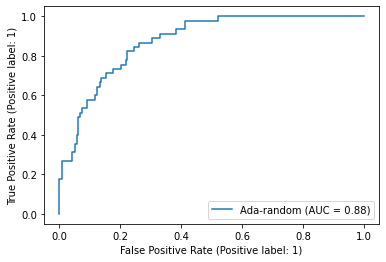

In [425]:
#Evaluating the model performance
print('AdaBoost classifier with hyperparameter from Grid Search on X_rnd data and tested on X_test')
create_results(y_test, prediction18)
plot_cm(y_test, prediction18, name='Ada-random Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(ada_model, X_test, y_test, name='Ada-random')

In [463]:
#RandomForestClassifier on imbalanced data
rfc = RandomForestClassifier(n_estimators=1000, random_state=25, criterion='gini')
rfc.fit(doc_features, doc_labels.values.ravel())
cross_score_22 = cross_val_score(rfc, doc_features, doc_labels.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction23 = rfc.predict(X_test)


Random Forest Classifier trained on X_sm data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       211
           1       0.59      0.49      0.54        45

    accuracy                           0.85       256
   macro avg       0.74      0.71      0.72       256
weighted avg       0.84      0.85      0.85       256


[[196  15]
 [ 23  22]]

Healthy Individuals Detected (True Negatives):  196
Healthy Individuals Incorrectly Detected (False Positives):  15
Covid-19 Patients not detected  (False Negatives):  23
Covid-19 Patients Detected (True Positives):  22
Total Covid-19 Patients in Data:  45

Specificity :  0.9289099526066351
Sensitivity :  0.4888888888888889
Precision :  0.5945945945945946
F1-Score :  0.5365853658536586

Roc curve on test set: 


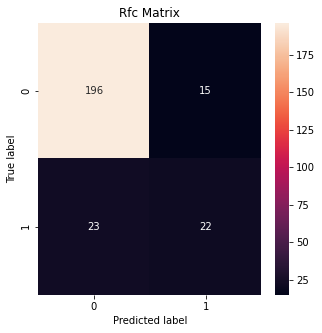

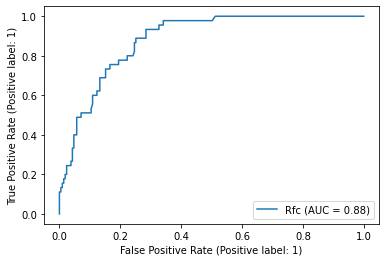

In [464]:
#Evaluating the model performance
print('Random Forest Classifier trained on X_sm data and tested on X_test')
create_results(y_test, prediction23)
plot_cm(y_test, prediction23, name='Rfc Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(rfc, X_test, y_test, name='Rfc')

In [158]:
#RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=25, criterion='gini')
rfc.fit(X_sm, y_sm)
cross_score_18 = cross_val_score(rfc, X_sm, y_sm.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction19 = rfc.predict(X_test)



<ipython-input-158-e2f5f597e23c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_sm, y_sm)


Random Forest Classifier trained on X_sm data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.99      0.64      0.78       211
           1       0.37      0.98      0.54        45

    accuracy                           0.70       256
   macro avg       0.68      0.81      0.66       256
weighted avg       0.88      0.70      0.74       256


[[136  75]
 [  1  44]]

Healthy Individuals Detected (True Negatives):  136
Healthy Individuals Incorrectly Detected (False Positives):  75
Covid-19 Patients not detected  (False Negatives):  1
Covid-19 Patients Detected (True Positives):  44
Total Covid-19 Patients in Data:  45

Specificity :  0.6445497630331753
Sensitivity :  0.9777777777777777
Precision :  0.3697478991596639
F1-Score :  0.5365853658536586

Roc curve on test set: 


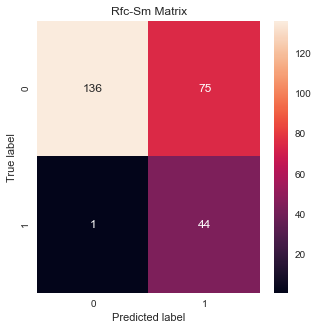

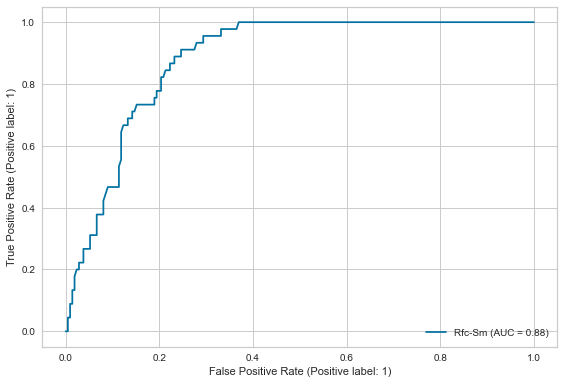

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='relative importance'>,
                   estimator=RandomForestClassifier(n_estimators=1000,
                                                    random_state=25),
                   topn=10)

In [159]:
#Evaluating the model performance
print('Random Forest Classifier trained on X_sm data and tested on X_test')
create_results(y_test, prediction19)
plot_cm(y_test, prediction19, name='Rfc-Sm Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(rfc, X_test, y_test, name='Rfc-Sm')
feature_importances(estimator=rfc, X=X_sm, y=y_sm, ax=axs[4,0], topn=10)


In [160]:
axs[4, 0].set_title('Rfc-Sm',fontsize=20)

Text(0.5, 1.0, 'Rfc-Sm')

In [161]:
#RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=25, criterion='gini')
rfc.fit(X_sm2, y_sm2)
cross_score_19 = cross_val_score(rfc, X_sm2, y_sm2.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction20 = rfc.predict(X_test)

<ipython-input-161-c235e477c4e9>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_sm2, y_sm2)


Random Forest Classifier trained on X_sm2 data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.98      0.74      0.85       211
           1       0.44      0.93      0.60        45

    accuracy                           0.78       256
   macro avg       0.71      0.84      0.72       256
weighted avg       0.89      0.78      0.80       256


[[157  54]
 [  3  42]]

Healthy Individuals Detected (True Negatives):  157
Healthy Individuals Incorrectly Detected (False Positives):  54
Covid-19 Patients not detected  (False Negatives):  3
Covid-19 Patients Detected (True Positives):  42
Total Covid-19 Patients in Data:  45

Specificity :  0.7440758293838863
Sensitivity :  0.9333333333333333
Precision :  0.4375
F1-Score :  0.5957446808510638

Roc curve on test set: 


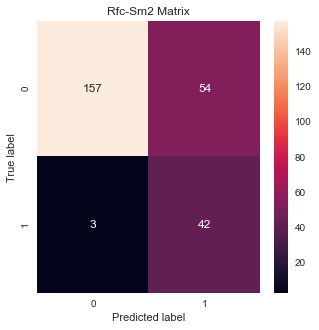

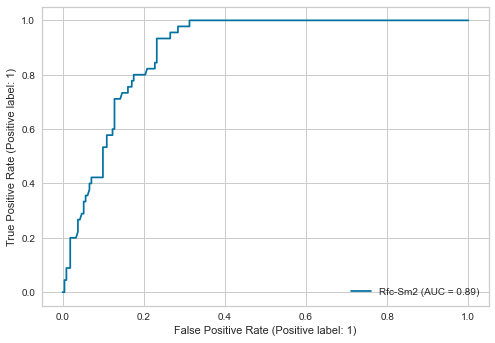

In [162]:
#Evaluating the model performance
print('Random Forest Classifier trained on X_sm2 data and tested on X_test')
create_results(y_test, prediction20)
plot_cm(y_test, prediction20, name='Rfc-Sm2 Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(rfc, X_test, y_test, name='Rfc-Sm2')

In [163]:
feature_importances(estimator=rfc, X=X_sm2, y=y_sm2, ax=axs[4,1], topn=10)
axs[4, 1].set_title('Rfc-Sm2',fontsize=20)


<Figure size 576x396 with 0 Axes>

Text(0.5, 1.0, 'Rfc-Sm2')

In [91]:
#RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=25, criterion='gini')
rfc.fit(X_bsm, y_bsm)
cross_score_20 = cross_val_score(rfc, X_bsm, y_bsm.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction21 = rfc.predict(X_test)

<ipython-input-91-1d8e8d1e5850>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_bsm, y_bsm)


Random Forest Classifier trained on X_bsm data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       211
           1       0.44      0.89      0.59        45

    accuracy                           0.78       256
   macro avg       0.70      0.82      0.72       256
weighted avg       0.88      0.78      0.80       256


[[160  51]
 [  5  40]]

Healthy Individuals Detected (True Negatives):  160
Healthy Individuals Incorrectly Detected (False Positives):  51
Covid-19 Patients not detected  (False Negatives):  5
Covid-19 Patients Detected (True Positives):  40
Total Covid-19 Patients in Data:  45

Specificity :  0.7582938388625592
Sensitivity :  0.8888888888888888
Precision :  0.43956043956043955
F1-Score :  0.5882352941176471

Roc curve on test set: 


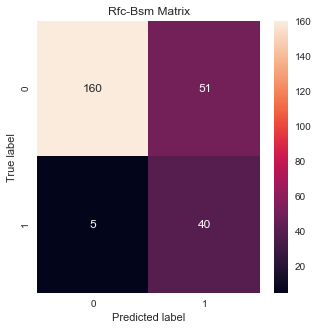

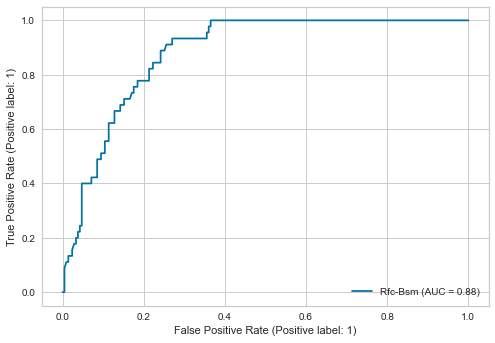

In [92]:
#Evaluating the model performance
print('Random Forest Classifier trained on X_bsm data and tested on X_test')
create_results(y_test, prediction21)
plot_cm(y_test, prediction21, name='Rfc-Bsm Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(rfc, X_test, y_test, name='Rfc-Bsm')

In [442]:
#RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=25, criterion='gini')
rfc.fit(X_ada, y_ada)
cross_score_21 = cross_val_score(rfc, X_ada, y_ada.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction22 = rfc.predict(X_test)

<ipython-input-442-4f7a42957ddc>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_ada, y_ada)


Random Forest Classifier trained on X_ada data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.98      0.73      0.83       211
           1       0.42      0.93      0.58        45

    accuracy                           0.76       256
   macro avg       0.70      0.83      0.71       256
weighted avg       0.88      0.76      0.79       256


[[153  58]
 [  3  42]]

Healthy Individuals Detected (True Negatives):  153
Healthy Individuals Incorrectly Detected (False Positives):  58
Covid-19 Patients not detected  (False Negatives):  3
Covid-19 Patients Detected (True Positives):  42
Total Covid-19 Patients in Data:  45

Specificity :  0.7251184834123223
Sensitivity :  0.9333333333333333
Precision :  0.42
F1-Score :  0.5793103448275863

Roc curve on test set: 


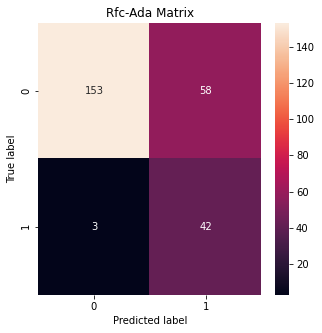

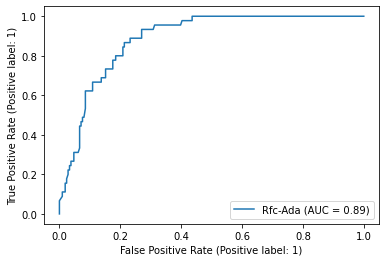

In [443]:
#Evaluating the model performance
print('Random Forest Classifier trained on X_ada data and tested on X_test')
create_results(y_test, prediction22)
plot_cm(y_test, prediction22, name='Rfc-Ada Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(rfc, X_test, y_test, name='Rfc-Ada')

In [465]:
#RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=25, criterion='gini')
rfc.fit(X_rnd, y_rnd)
cross_score_23 = cross_val_score(rfc, X_rnd, y_rnd.values.ravel(), cv=cv_split, scoring='f1_macro')
prediction24 = rfc.predict(X_test)

<ipython-input-465-7147ecac58b6>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_rnd, y_rnd)


Random Forest Classifier trained on X_ada data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       211
           1       0.41      0.87      0.56        45

    accuracy                           0.76       256
   macro avg       0.69      0.80      0.70       256
weighted avg       0.87      0.76      0.78       256


[[155  56]
 [  6  39]]

Healthy Individuals Detected (True Negatives):  155
Healthy Individuals Incorrectly Detected (False Positives):  56
Covid-19 Patients not detected  (False Negatives):  6
Covid-19 Patients Detected (True Positives):  39
Total Covid-19 Patients in Data:  45

Specificity :  0.7345971563981043
Sensitivity :  0.8666666666666667
Precision :  0.4105263157894737
F1-Score :  0.5571428571428572

Roc curve on test set: 


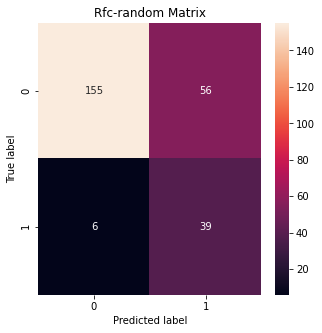

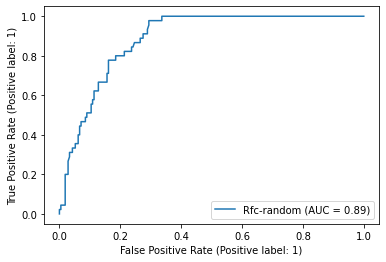

In [466]:
#Evaluating the model performance
print('Random Forest Classifier trained on X_rnd data and tested on X_test')
create_results(y_test, prediction24)
plot_cm(y_test, prediction24, name='Rfc-random Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(rfc, X_test, y_test, name='Rfc-random')

In [104]:
xgb4.fit(doc_features, doc_labels)
cross_score_xgb = cross_val_score(xgb4, doc_features, doc_labels, cv=cv_split, scoring='f1_macro')
prediction_xgb=xgb4.predict(X_test)

Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on imbalanced data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       211
           1       0.53      0.60      0.56        45

    accuracy                           0.84       256
   macro avg       0.72      0.74      0.73       256
weighted avg       0.84      0.84      0.84       256


[[187  24]
 [ 18  27]]

Healthy Individuals Detected (True Negatives):  187
Healthy Individuals Incorrectly Detected (False Positives):  24
Covid-19 Patients not detected  (False Negatives):  18
Covid-19 Patients Detected (True Positives):  27
Total Covid-19 Patients in Data:  45

Specificity :  0.8862559241706162
Sensitivity :  0.6
Precision :  0.5294117647058824
F1-Score :  0.5625

Roc curve on test set: 


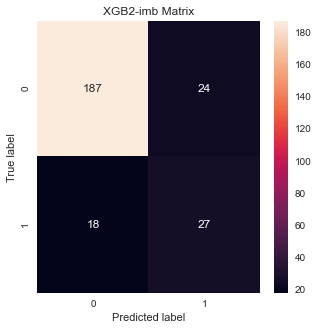

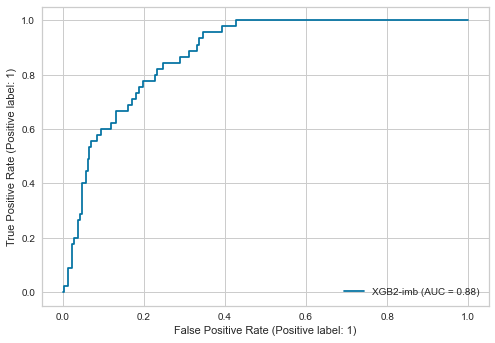

In [105]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter tuned on 1st generated data as xgb4 and trained on imbalanced data and tested on X_test')
create_results(y_test, prediction_xgb)
plot_cm(y_test, prediction_xgb, name='XGB2-imb Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb4, X_test, y_test, name='XGB2-imb')

In [483]:
xgb6.fit(doc_features, doc_labels)
cross_score_xgb2 = cross_val_score(xgb6, doc_features, doc_labels, cv=cv_split, scoring='f1_macro')
prediction_xgb2=xgb6.predict(X_test)

Xgboost classifier with hyperparameter as xgb6 and trained on imbalanced data and tested on X_test

XGBClassifier: 

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       211
           1       0.55      0.60      0.57        45

    accuracy                           0.84       256
   macro avg       0.73      0.75      0.74       256
weighted avg       0.85      0.84      0.85       256


[[189  22]
 [ 18  27]]

Healthy Individuals Detected (True Negatives):  189
Healthy Individuals Incorrectly Detected (False Positives):  22
Covid-19 Patients not detected  (False Negatives):  18
Covid-19 Patients Detected (True Positives):  27
Total Covid-19 Patients in Data:  45

Specificity :  0.8957345971563981
Sensitivity :  0.6
Precision :  0.5510204081632653
F1-Score :  0.574468085106383

Roc curve on test set: 


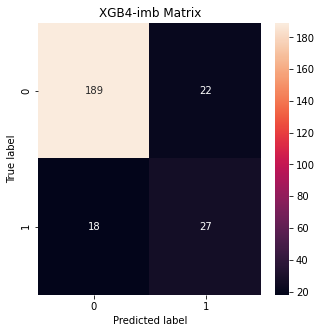

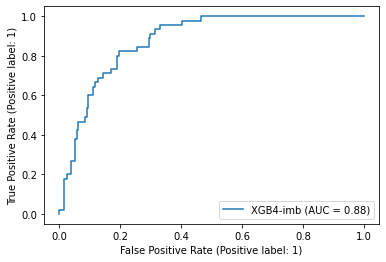

In [484]:
#Evaluating the model performance
print('Xgboost classifier with hyperparameter as xgb6 and trained on imbalanced data and tested on X_test')
create_results(y_test, prediction_xgb2)
plot_cm(y_test, prediction_xgb2, name='XGB3-imb Matrix')
print('Roc curve on test set: ')
metrics.plot_roc_curve(xgb6, X_test, y_test, name='XGB3-imb')

In [61]:
#saving the generated data sets for Eda
Generation1= pd.concat((X_sm, y_sm), axis=1)
Generation2= pd.concat((X_sm2, y_sm2), axis=1)



In [ ]:
Generation1.to_csv('Generation1.csv', index=False)
Generation2.to_csv('Generation2.csv', index=False)


In [93]:
Generation_bsm = pd.concat((X_bsm,y_bsm), axis=1)
Generation_ada = pd.concat((X_ada,y_ada), axis=1)
Generation_rnd = pd.concat((X_rnd, y_rnd), axis=1)


In [115]:
#PCA for comparison and visualisation
print("PCA dataset for Generated dataset 1")
Generated_1_PCA = PCA_data(data_new=Generation1)
print(Generated_1_PCA)

PCA dataset for Generated dataset 1
Explained Variance Ratio: 
[0.15828714 0.13981221]
      principal component 1  principal component 2  tested_positive
0                 -0.629630               0.005981                0
1                  0.618833               0.560083                0
2                  0.397354               0.423037                0
3                 -0.609540              -0.087113                0
4                 -0.669448              -0.008671                0
...                     ...                    ...              ...
3878               0.663194               0.256376                1
3879               0.656687               0.095289                1
3880              -0.341664              -0.300176                1
3881              -0.385868              -0.266340                1
3882              -0.182751              -0.429778                1

[3883 rows x 3 columns]


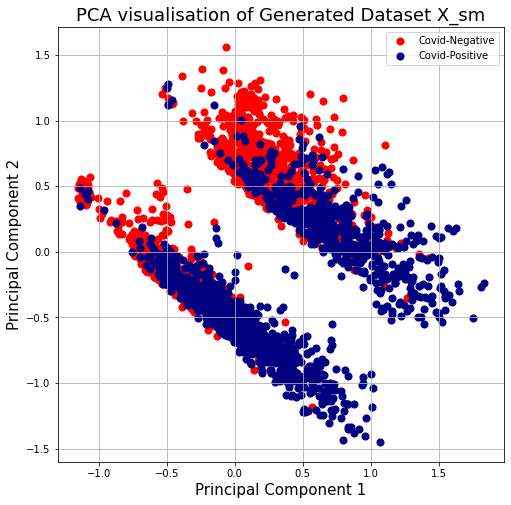

In [119]:
fig3 = plt.figure(figsize = (8,8))
ax3 = fig3.add_subplot(1,1,1) 
ax3.set_xlabel('Principal Component 1', fontsize = 15)
ax3.set_ylabel('Principal Component 2', fontsize = 15)
ax3.set_title('PCA visualisation of Generated Dataset X_sm', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = Generated_1_PCA['tested_positive'] == target
    ax3.scatter(Generated_1_PCA.loc[indicesToKeep, 'principal component 1']
               , Generated_1_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax3.legend(legends)
ax3.grid()

In [62]:
#PCA for comparison and visualisation
print("PCA dataset for Generated dataset 2")
Generated_2_PCA = PCA_data(data_new=Generation2)
print(Generated_2_PCA)

PCA dataset for Generated dataset 2
Explained Variance Ratio: 
[0.15896406 0.13633477]
      principal component 1  principal component 2  tested_positive
0                 -0.566912              -0.133098                0
1                  0.854457              -0.312741                0
2                  0.598749              -0.173401                0
3                 -0.524813              -0.054605                0
4                 -0.611799              -0.136926                0
...                     ...                    ...              ...
5173              -0.080016               0.488805                1
5174              -0.110649               0.629482                1
5175              -0.074310               0.751088                1
5176              -0.267493               0.434607                1
5177              -0.089025               0.582639                1

[5178 rows x 3 columns]


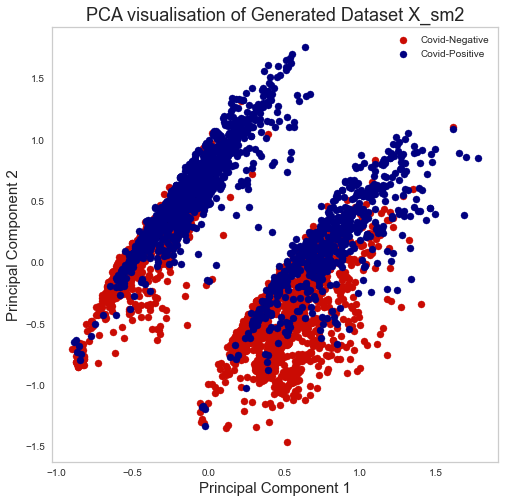

In [63]:
fig4 = plt.figure(figsize = (8,8))
ax4 = fig4.add_subplot(1,1,1) 
ax4.set_xlabel('Principal Component 1', fontsize = 15)
ax4.set_ylabel('Principal Component 2', fontsize = 15)
ax4.set_title('PCA visualisation of Generated Dataset X_sm2', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = Generated_2_PCA['tested_positive'] == target
    ax4.scatter(Generated_2_PCA.loc[indicesToKeep, 'principal component 1']
               , Generated_2_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax4.legend(legends)
ax4.grid()

In [94]:
#PCA for comparison and visualisation
print("PCA dataset for Generated dataset 1")
Generated_bsm_PCA = PCA_data(data_new=Generation_bsm)
print(Generated_bsm_PCA)

PCA dataset for Generated dataset 1
Explained Variance Ratio: 
[0.16472555 0.13468341]
      principal component 1  principal component 2  tested_positive
0                  0.167691              -0.709162                0
1                 -0.532368              -0.098999                0
2                 -0.519996              -0.121096                0
3                  0.333261              -0.352595                0
4                 -0.568167               0.019911                0
...                     ...                    ...              ...
5173              -0.164331               0.407774                1
5174               0.888564               0.370670                1
5175              -0.244585               0.391082                1
5176               0.234996               1.200466                1
5177               0.411556               1.272104                1

[5178 rows x 3 columns]


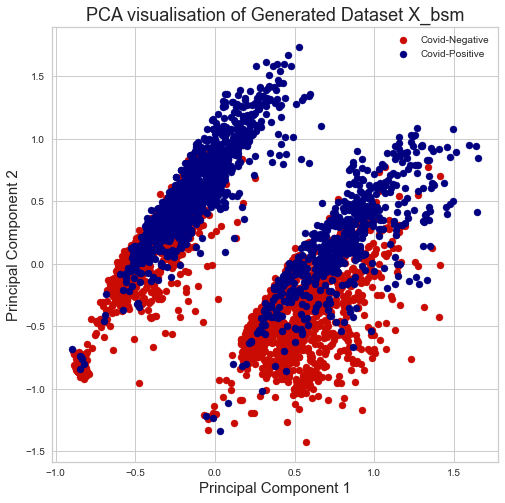

In [95]:
fig6 = plt.figure(figsize = (8,8))
ax6 = fig6.add_subplot(1,1,1) 
ax6.set_xlabel('Principal Component 1', fontsize = 15)
ax6.set_ylabel('Principal Component 2', fontsize = 15)
ax6.set_title('PCA visualisation of Generated Dataset X_bsm', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = Generated_bsm_PCA['tested_positive'] == target
    ax6.scatter(Generated_bsm_PCA.loc[indicesToKeep, 'principal component 1']
               , Generated_bsm_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax6.legend(legends)
ax6.grid(b=True, which='major')

In [23]:
#PCA for comparison and visualisation
print("PCA dataset for Generated dataset 1")
Generated_ada_PCA = PCA_data(data_new=Generation_ada)
print(Generated_ada_PCA)

PCA dataset for Generated dataset 1
Explained Variance Ratio: 
[0.15732101 0.13414476]
      principal component 1  principal component 2  tested_positive
0                 -0.498511              -0.066195                0
1                  0.610966              -0.018803                0
2                 -0.573314              -0.308913                0
3                  0.253181              -0.634634                0
4                  0.284901              -0.641703                0
...                     ...                    ...              ...
4537               0.747344               0.378519                1
4538               0.706745               0.117621                1
4539              -0.037212               0.816944                1
4540              -0.209240               0.528964                1
4541              -0.490410              -0.020161                1

[4542 rows x 3 columns]


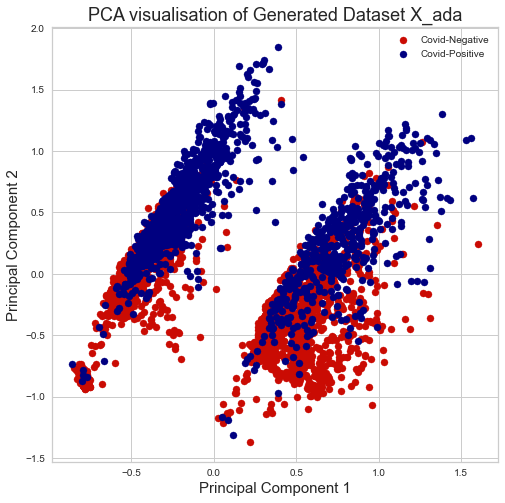

In [34]:
fig7 = plt.figure(figsize = (8,8))
ax7 = fig7.add_subplot(1,1,1) 
ax7.set_xlabel('Principal Component 1', fontsize = 15)
ax7.set_ylabel('Principal Component 2', fontsize = 15)
ax7.set_title('PCA visualisation of Generated Dataset X_ada', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = Generated_ada_PCA['tested_positive'] == target
    ax7.scatter(Generated_ada_PCA.loc[indicesToKeep, 'principal component 1']
               , Generated_ada_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax7.legend(legends)
ax7.grid(b=True, which='major')

In [64]:
#PCA for comparison and visualisation
print("PCA dataset for Generated dataset 1")
Generated_rnd_PCA = PCA_data(data_new=Generation_rnd)
print(Generated_rnd_PCA)

PCA dataset for Generated dataset 1
Explained Variance Ratio: 
[0.17242087 0.12427248]
      principal component 1  principal component 2  tested_positive
0                 -0.520590               0.118630                0
1                  0.170578              -0.690026                0
2                 -0.521427               0.093926                0
3                 -0.538904               0.137265                0
4                 -0.659534              -0.069441                0
...                     ...                    ...              ...
5173               0.694706              -0.020035                1
5174               0.054363               1.147659                1
5175               0.666963              -0.033501                1
5176              -0.341013               0.176514                1
5177               0.469842              -0.306338                1

[5178 rows x 3 columns]


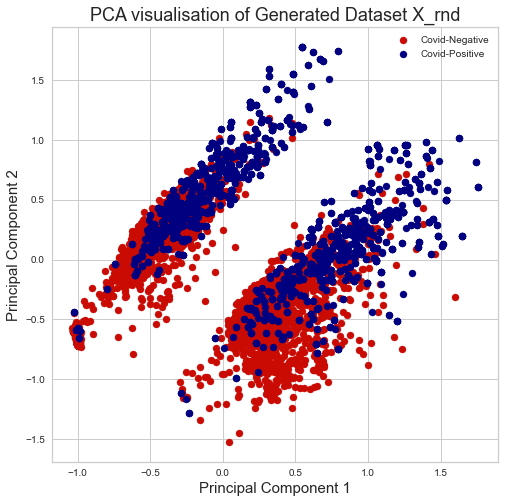

In [66]:
fig8 = plt.figure(figsize = (8,8))
ax8 = fig8.add_subplot(1,1,1) 
ax8.set_xlabel('Principal Component 1', fontsize = 15)
ax8.set_ylabel('Principal Component 2', fontsize = 15)
ax8.set_title('PCA visualisation of Generated Dataset X_rnd', fontsize = 18)
targets = [0, 1]
colors = ['r', 'navy']
for target, color in zip(targets,colors):
    indicesToKeep = Generated_rnd_PCA['tested_positive'] == target
    ax8.scatter(Generated_rnd_PCA.loc[indicesToKeep, 'principal component 1']
               , Generated_rnd_PCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
legends = ['Covid-Negative', 'Covid-Positive']
ax8.legend(legends)
ax8.grid(b=True, which='major')

In [137]:
fig.savefig('no_pcr_pca.jpeg')
fig2.savefig('pcr_pca.jpeg')
fig3.savefig('X_sm_pca.jpeg')
fig4.savefig('X_sm2_pca.jpeg')
fig5.savefig('training_data_pca.jpeg')

In [96]:
fig6.savefig('X_bsm_pca.jpeg')
fig7.savefig('X_ada_pca.jpeg')
fig8.savefig('X_rnd_pca.jpeg')

In [475]:
#Dictionary of the cross validation scores

cv_score_dict = {'XGB1':cross_score_1, 'XGB2':cross_score_2, 'XGB3':cross_score_3, 
                 'XGB4':cross_score_4, 'XGB3-sm2':cross_score_5, 'XGB4-sm2':cross_score_6, 
                }

In [476]:
cv_score_df = pd.DataFrame(cv_score_dict)
print(cv_score_df)

        XGB1      XGB2      XGB3      XGB4  XGB3-sm2  XGB4-sm2
0   0.712088  0.903012  0.912325  0.910104  0.905162  0.904699
1   0.705836  0.900803  0.898703  0.898684  0.908655  0.910998
2   0.733607  0.916480  0.912690  0.917837  0.902650  0.901447
3   0.710614  0.904839  0.907281  0.907709  0.914112  0.914472
4   0.707672  0.904268  0.915575  0.916559  0.911816  0.909418
5   0.719378  0.896525  0.899563  0.899988  0.904272  0.907064
6   0.735659  0.906595  0.908988  0.907850  0.904865  0.902721
7   0.713404  0.905738  0.909178  0.909711  0.915405  0.914173
8   0.727628  0.906788  0.910170  0.909079  0.904348  0.899883
9   0.727536  0.897758  0.897281  0.899273  0.911297  0.907580
10  0.726026  0.911127  0.914532  0.916086  0.904362  0.907965
11  0.731904  0.903793  0.903686  0.902155  0.910845  0.904107
12  0.709819  0.908867  0.908661  0.908661  0.905705  0.911403
13  0.718232  0.910243  0.912582  0.909534  0.901683  0.899348
14  0.712904  0.909683  0.905980  0.914752  0.904827  0

In [194]:
cv_score_df.to_csv('CV_score.csv', index=False)

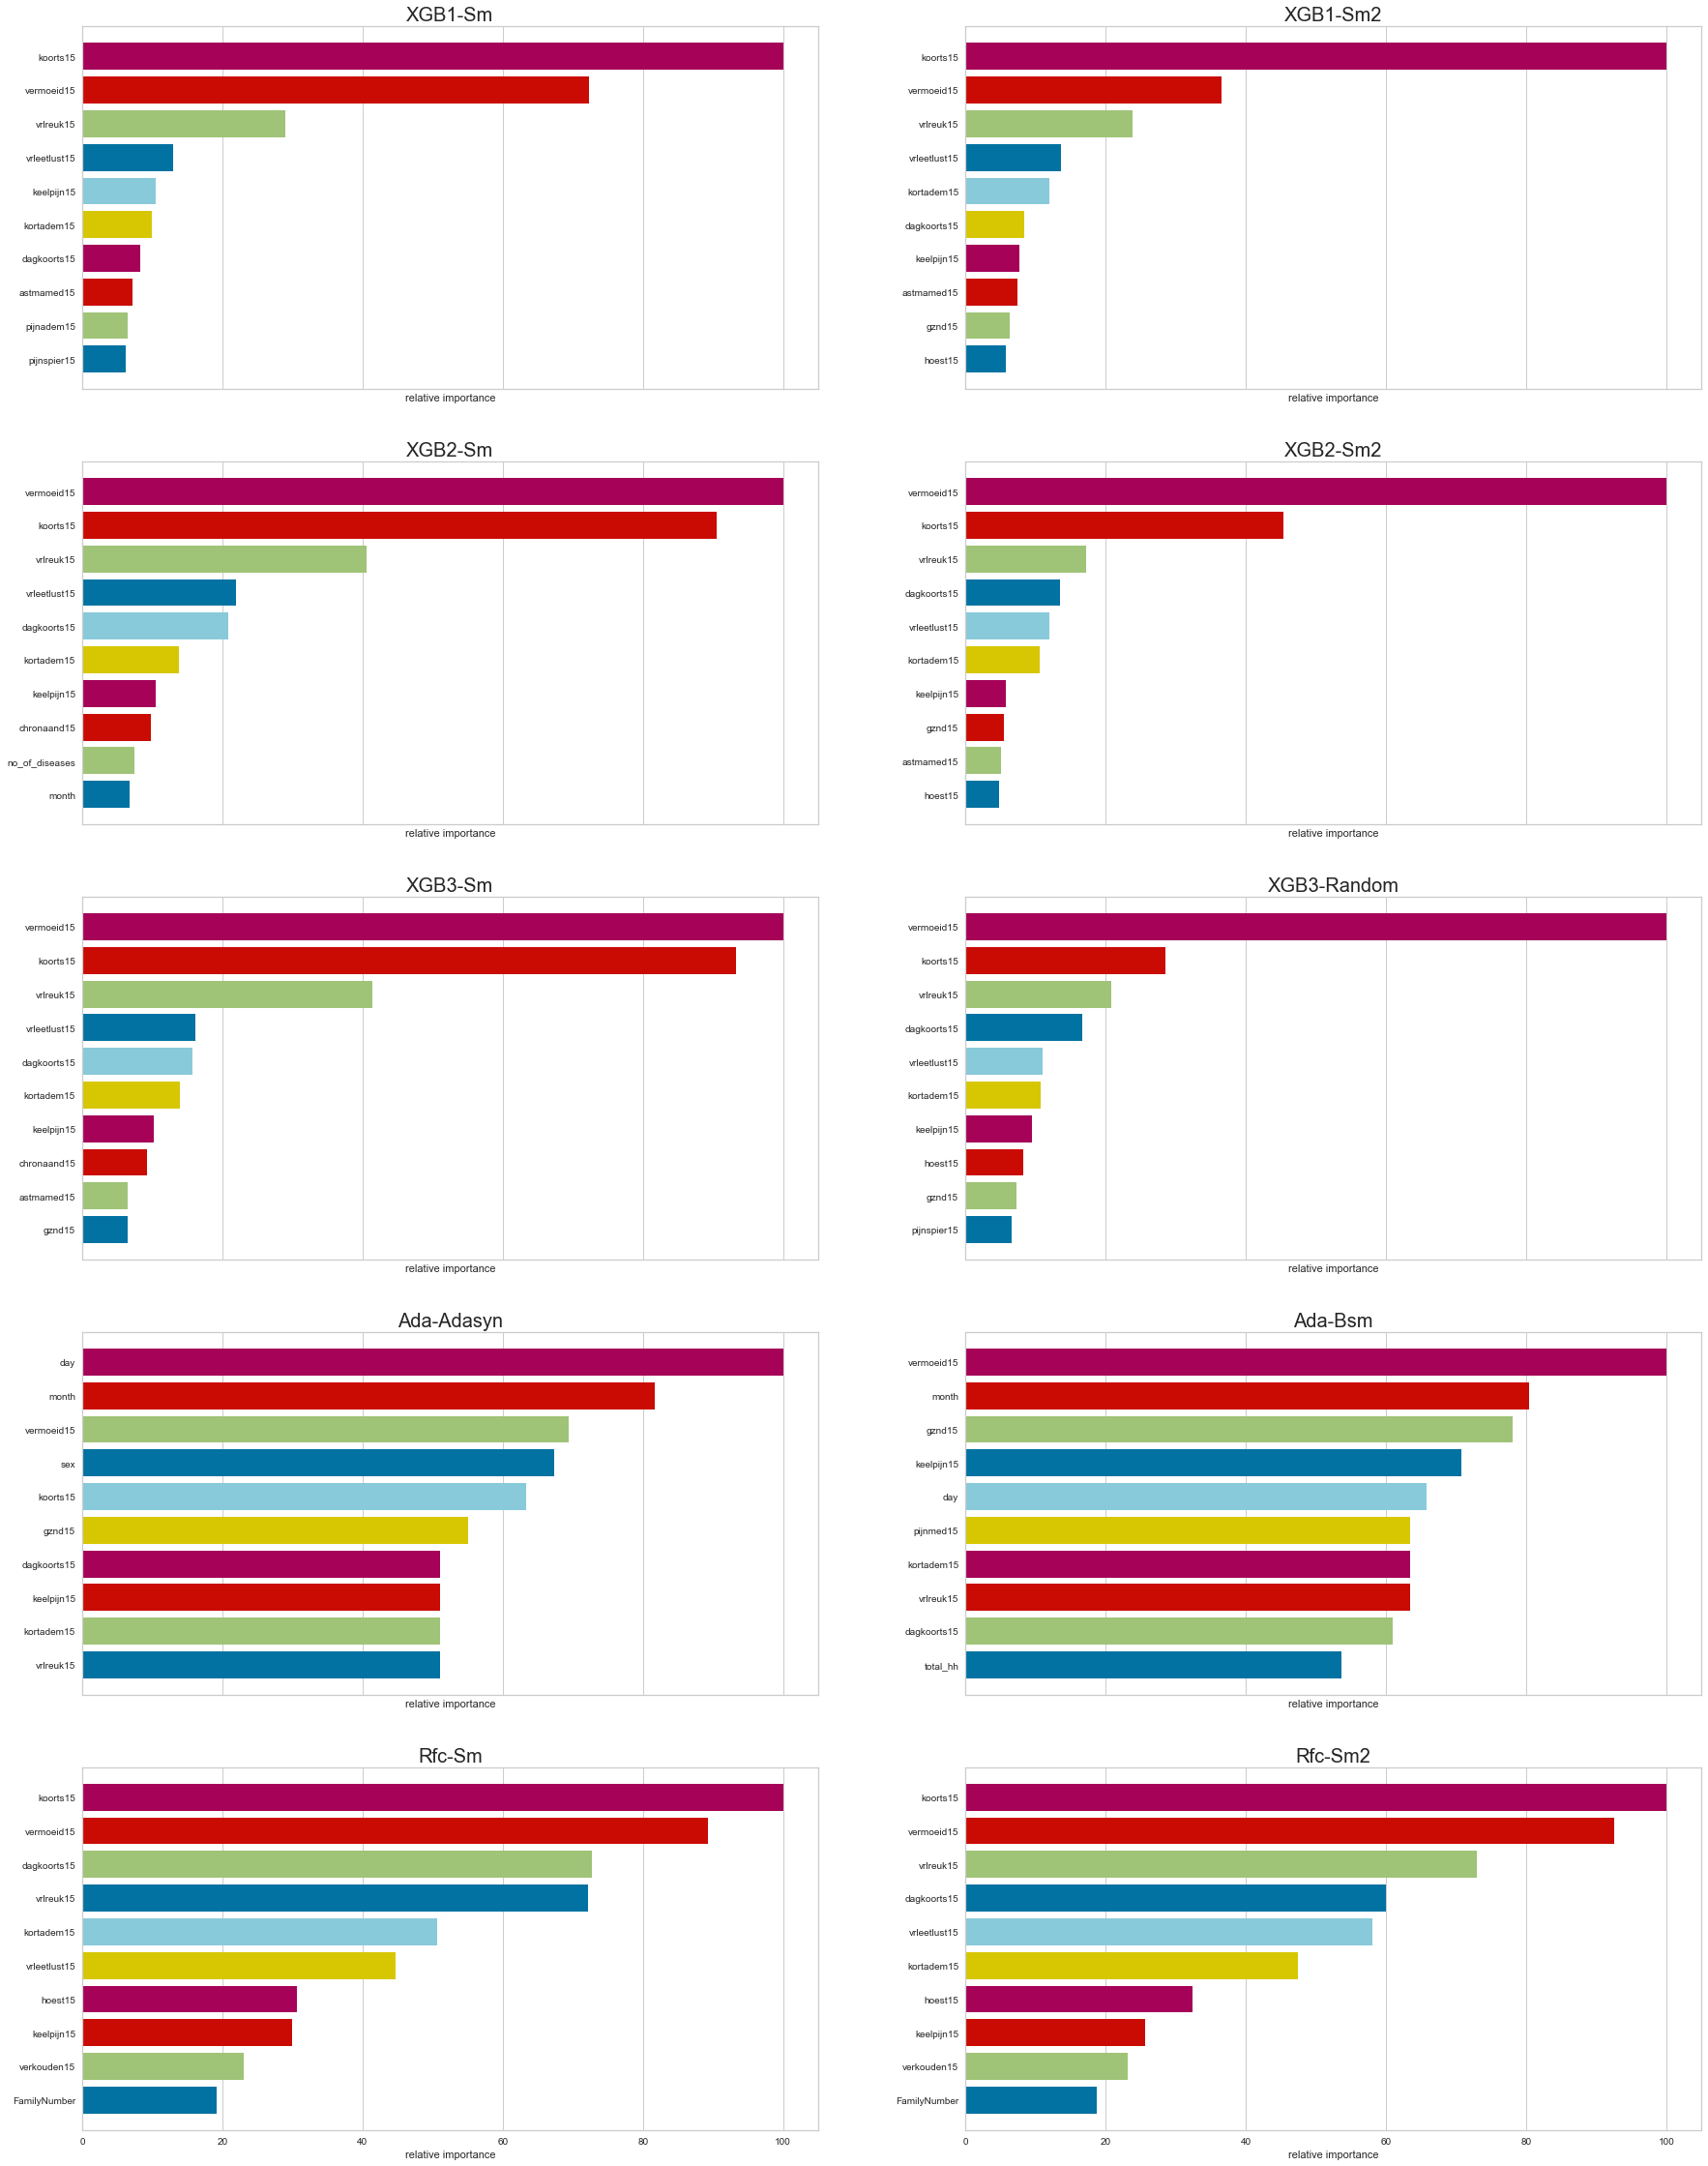

In [170]:
fig_feat

In [174]:
fig_feat.savefig('Feature_Importance.png', bbox_inches='tight')